<div class="alert alert-success">
<font size="4"><b>Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
    Привет, Ярослав :) Спасибо, что прислал задание 🤝 Меня зовут Ринат Хисамов и я буду проверять твой проект. Предлагаю обращаться друг к другу на ты. Так нам будет гораздо проще и удобней общаться

Мои комментарии обозначены пометкой <b>Комментарий ревьюера</b>. Далее в файле сможешь найти их в похожих ячейках (если фон комментария зелёный — всё сделано правильно (✔️), рекомендации таким же цветом. Отдельным цветом — блок ссылок (примеры ниже, 🍕). Оранжевым или светло желтым рекомендации, которые, хоть и не обязательны, но точно сделают ревью лучше. (⚠️); <u> красный комментарий</u>: код, график или вывод стоит переделать (❌)). 

Не удаляй все эти комментарии и постарайся учесть их в ходе выполнения данного проекта. 
Будет замечательно, если добавишь свои комментарии и пояснения✍
        
__Увидев у тебя неточность, в первый раз я лишь укажу на ее наличие, а ты попробуешь исправить ее самостоятельно. Но если ты пока не справишься с такой задачей — при следующей проверке я дам более подробную подсказку!__        
        
Поехали 🚀
    <br />
    </font>

</div>

<div style="border:solid steelblue 1px; padding: 20px">
    
<font size="4"><p style="text-align:center"><b>Примеры комментариев </b></p></font>
    
<div style="border:solid steelblue 3px; padding: 20px">
<font size="4"><b>🍕 Пример комментария - совета, здесь м.б. просто ссылка</b></font>
    <br /> 
        <font size="3", color = "black">
<br />
    Тут всего такого разного и вкусного :), есть способы прокачать проект визуализациями (ценит большинство "боссов")  <br /><br />
        <a href="https://devpractice.ru/matplotlib-book/">“Библиотека Matplotlib” доступна для скачивания БЕСПЛАТНО!</a>
        На сайте много полезных материалов, мне самому очень помогло в свое время, до сих пор подсматриваю :)


</div>
    
<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
    <font size="3"><b>⚠️ Пример оформления некритичного комментария</b>
    <br /> 
    <font size="2", color = "black">
<br />
    Рекомендации, которые, хоть и не обязательны, но точно сделают ревью лучше
    <br />
    </font>

</div>
    
<div class="alert alert-danger">
<font size="3"><b>❌ Пример оформления комментария к блоку(строке) программного кода (или выводу), который стоит переделать</b></font>
    <br /> 
    <font size="2", color = "black">
<br />
    Отправлен не тот проект, напиши в своих комментариях, что случилось? жду — <b>это пример</b>
    <br />
    </font>

</div>
    
<div class="alert alert-success">
<font size="4"><b>✔️ Пример оформления комментария, который нравится большинству студентов</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
    Круто, молодец, отлично, логично, или — 👌, 👍, или — выводы отвечают на все вопросы к данным и проекту
    <br />
    </font>

</div>

# Для твоих вопросов или комментариев оставлю такую ячейку, чтобы было удобнее взаимодействовать на проекте

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> ... , вот мой вопрос ...
        
        

# Исследование трендов российского кинопроката

Нужно изучить рынок российского кинопроката и выявить текущие тренды.

Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

## Описание данных:
У одного фильма может быть несколько прокатных удостоверений. 
- `title` — название фильма;
- `pu_number` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.
- `pu_number` — номер прокатного удостоверения;
- `box_office` — сборы в рублях.

Столбец `budget` уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку. 

Задача предполагает предобработку и EDA. На этапе предобработки наиболбшую сложность составляют преобразования типов, объединение наборов данных и фильтрация неявных дубликатов в столбце `title`.

EDA описан в Сборном проекте 1 в Яндекс.Практикуме. Особую сложность составляет анализ трендов кинопроката в зависимости от государственного субсидирования т.к. эта задача свормулирована очень абстрактно и не содержит конуретных шагов по методологии выполнения.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит добавить подробностей, без которых тяжело будет вспомнить через полгода суть проекта (без отдельного брифа проекта)

<div class="alert alert-info">
<font size="4", color = "black">Добавил краткое описание сути проекта.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

In [1]:
# !python -m pip install Levenshtein

In [2]:
import pandas as pd
import numpy as np
from Levenshtein import distance
from matplotlib import pyplot as plt
from datetime import datetime as dt

## Подготовка данных

### Откроем файл с данными и изучим общую информацию

In [3]:
try:
    df1 = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_1\source\mkrf_movies.csv")
    df2 = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_1\source\mkrf_shows.csv")
except:
    df1 = pd.read_csv("/datasets/mkrf_movies.csv")
    df2 = pd.read_csv("/datasets/mkrf_shows.csv")

pd.set_option('display.max_columns', None)
print(df1.head(20))
print(df2.head(20))


                                                title   puNumber  \
0                                    Открытый простор  221048915   
1                                Особо важное задание  111013716   
2                                        Особо опасен  221038416   
3                                        Особо опасен  221026916   
4                                        Особо опасен  221030815   
5                                   Остановился поезд  111013816   
6                                     Любовь и голуби  111007013   
7                                   Любовь и сигареты  221074614   
8                                  Отпетые мошенники.  121011416   
9                                 Отпуск за свой счет  111019114   
10  Превосходство Борна /По одноименной новелле Ро...  221031416   
11                                       Ответный ход  111019014   
12  Малышка на миллион /По мотивам рассказов Ф.Х.Т...  221011415   
13                                 Преданный сад

Преобразуем колонки к соответствующим типам данных.

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Сохраним количество записей до всех преобразований.

In [5]:
before_puring = df1.count()
print(f"Записей было до начала чистки: {before_puring}.")

Записей было до начала чистки: title                    7486
puNumber                 7486
show_start_date          7486
type                     7486
film_studio              7468
production_country       7484
director                 7477
producer                 6918
age_restriction          7486
refundable_support        332
nonrefundable_support     332
budget                    332
financing_source          332
ratings                  6519
genres                   6510
dtype: int64.


<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Все  методы можно собрать в функцию и оптимизировать код вывода первичной информации
        
        def ...:
            ... dataset.head()
            ... dataset.info()

<div class="alert alert-info">
<font size="4", color = "black">Не вижу в этом смысла т.к. на разных этапах я хочу посмотреть конкретную информацию, которая может быть получена вызовом конкретных методов, которые я использую.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

Поле `pu_number` содержит недопустимые для целочисленного типа значения. Точно так же поле `ratings` содержит недопустимые для вещественного типа значения. Преобразуем эти колонки к соответствующим типам через to_numeric() и оптимизируем типы для имеемых значений этих полей.

In [6]:
df1["puNumber"] = pd.to_numeric(df1["puNumber"], errors="coerce", downcast="integer")
ratings_before = df1["ratings"].count()
df1["ratings"] = pd.to_numeric(df1["ratings"], errors="coerce", downcast="float")
ratings_after = df1["ratings"].count()
print(f"До преобразования типа колонки ratings в ней было {ratings_before} записей. После стало {ratings_after}. Доля утерянных данных: {(100 - (100 * ratings_after / ratings_before)):.2f}%.")

До преобразования типа колонки ratings в ней было 6519 записей. После стало 6490. Доля утерянных данных: 0.44%.


Оценим полноту данных до и после преобразования колонки `ratings`.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br />  
    <font size="3", color = "black">
<br /> Стоит оценить потери в данных после кода
        
        df1["ratings"] = pd.to_numeric(df1["ratings"], errors="coerce", downcast="float")
        
и можно ли эти данные терять?        

<div class="alert alert-info">
<font size="4", color = "black">Количество утерянных данных невелико, качество данных улучшилось. Оставим так.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

In [7]:
df1 = df1.astype({"puNumber" : "UInt32", "show_start_date" : "datetime64"})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

In [8]:
# check
df1['show_start_date'] = df1['show_start_date'].dt.date
df1['show_start_date'][:1]

0    2015-11-27
Name: show_start_date, dtype: object

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Во время форматирования стоит избавиться от части информации, если она не несет пользу
        
        12:00:00+00:00

<div class="alert alert-info">
<font size="4", color = "black">Оставил только даты.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

Заметим, что поле `age_restriction` можно преобразовать к беззнаковому целыму типу. Преобразуем это поле. 

In [9]:
df1["age_restriction"] = pd.to_numeric(df1["age_restriction"] \
    .str.extract(r"(«\d*\+»)")[0].str.strip("«+»"), errors="coerce", downcast="unsigned")

Оптимизируем все строковые поля с уникальностью значений ниже 50%.

In [10]:
columns = df1.select_dtypes(include=['object'])

for col in columns:
    num_unique_values = len(df1[col].unique())
    num_total_values = len(df1[col])
    uniquness = num_unique_values / num_total_values

    print(col, f"uniquness is {uniquness * 100:.2f}%")

    if uniquness < 0.5:
        df1.loc[:,col] = df1[col].astype('category')
    else:
        df1.loc[:,col] = df1[col]

title uniquness is 90.46%
show_start_date uniquness is 26.25%
type uniquness is 0.11%
film_studio uniquness is 73.35%
production_country uniquness is 12.70%
director uniquness is 64.28%
producer uniquness is 71.47%
financing_source uniquness is 0.05%
genres uniquness is 9.93%


Проверим результат.

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  7486 non-null   object  
 1   puNumber               7485 non-null   UInt32  
 2   show_start_date        7486 non-null   category
 3   type                   7486 non-null   category
 4   film_studio            7468 non-null   object  
 5   production_country     7484 non-null   category
 6   director               7477 non-null   object  
 7   producer               6918 non-null   object  
 8   age_restriction        7486 non-null   uint8   
 9   refundable_support     332 non-null    float64 
 10  nonrefundable_support  332 non-null    float64 
 11  budget                 332 non-null    float64 
 12  financing_source       332 non-null    category
 13  ratings                6490 non-null   float32 
 14  genres                 6510 non-null   c

Так же преобразуем типы во втором датасете.

In [12]:
df2 = df2.astype({"puNumber" : "UInt32"})

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   UInt32 
 1   box_office  3158 non-null   float64
dtypes: UInt32(1), float64(1)
memory usage: 40.2 KB


Объединим эти данные в один DataFrame через left join df1 к df2 т.к. во втором содежжится только часть записей первого.

In [14]:
df = df1.merge(df2, on='puNumber', how='left')
df = df.rename({"puNumber" : "pu_number"}, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  7486 non-null   object  
 1   pu_number              7485 non-null   UInt32  
 2   show_start_date        7486 non-null   category
 3   type                   7486 non-null   category
 4   film_studio            7468 non-null   object  
 5   production_country     7484 non-null   category
 6   director               7477 non-null   object  
 7   producer               6918 non-null   object  
 8   age_restriction        7486 non-null   uint8   
 9   refundable_support     332 non-null    float64 
 10  nonrefundable_support  332 non-null    float64 
 11  budget                 332 non-null    float64 
 12  financing_source       332 non-null    category
 13  ratings                6490 non-null   float32 
 14  genres                 6510 non-null   c

После преобразований типов количество ненулевых записей в большинстве колонок не изменилось. В единственной колонке `ratings` было утеряно 0.44% данных. Также удалили запись без информации о финансировании картины с пропкуском в колонке `pu_number`. Это незначительное количество, поэтому продолжим подготовку данных дальше.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br />  
    <font size="3", color = "black">
<br />В реальной работе, перед объединением стоит более подробно изучить данные, например на наличие полных дубликатов

<div class="alert alert-info">
<font size="4", color = "black">Возьму на заметку, что лучше делать в такой последовательности. Чтобы не тратить много времени на преобразования кода в этот раз менять не буду.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера </b></font>
    <br /> 
    <font size="3", color = "black">
<br />   Стоит применять «змеиный стиль» в названиях переменных и колонках
        
        ['pu_number']
        
        ['pu_number']        
        
[Для чего придуман PEP8](https://letpy.com/python-guide/pep8/?ysclid=lkvf7o0xjl57413288)         

<div class="alert alert-info">
<font size="4", color = "black">Переименовал поле в соответствии с PEP8.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит обратить внимание на параметры, которые пандас выставляет по умолчанию при merge (для справки в join такая же «засада» по характеру, но другая по исполнению)
        
Использование параметров по умолчанию может привести к потере данных при объединении        
     
        
[Примеры объединения таблиц, merge](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.merge.html?highlight=merge#pandas.DataFrame.merge)  
        
[Примеры объединения таблиц, join](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join)          

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Можно добавить минивывод о результатах объединения, сохранилась ли размерность таблиц (по денежным колонкам особенно), не появились ли лишние пропуски
        
Заказчику эта таблица ничего не расскажет, т.к. он не исследовал эти данные, он не знает, что и с чем сравнивать      
        
 

<div class="alert alert-info">
<font size="4", color = "black">Добавил промежуточный вывод.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

### Обработаем пропуски

In [15]:
# check
# пропущенные значения бары

def pass_value_barh(dfg, title):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16, grid=True)
            .set_title(title + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

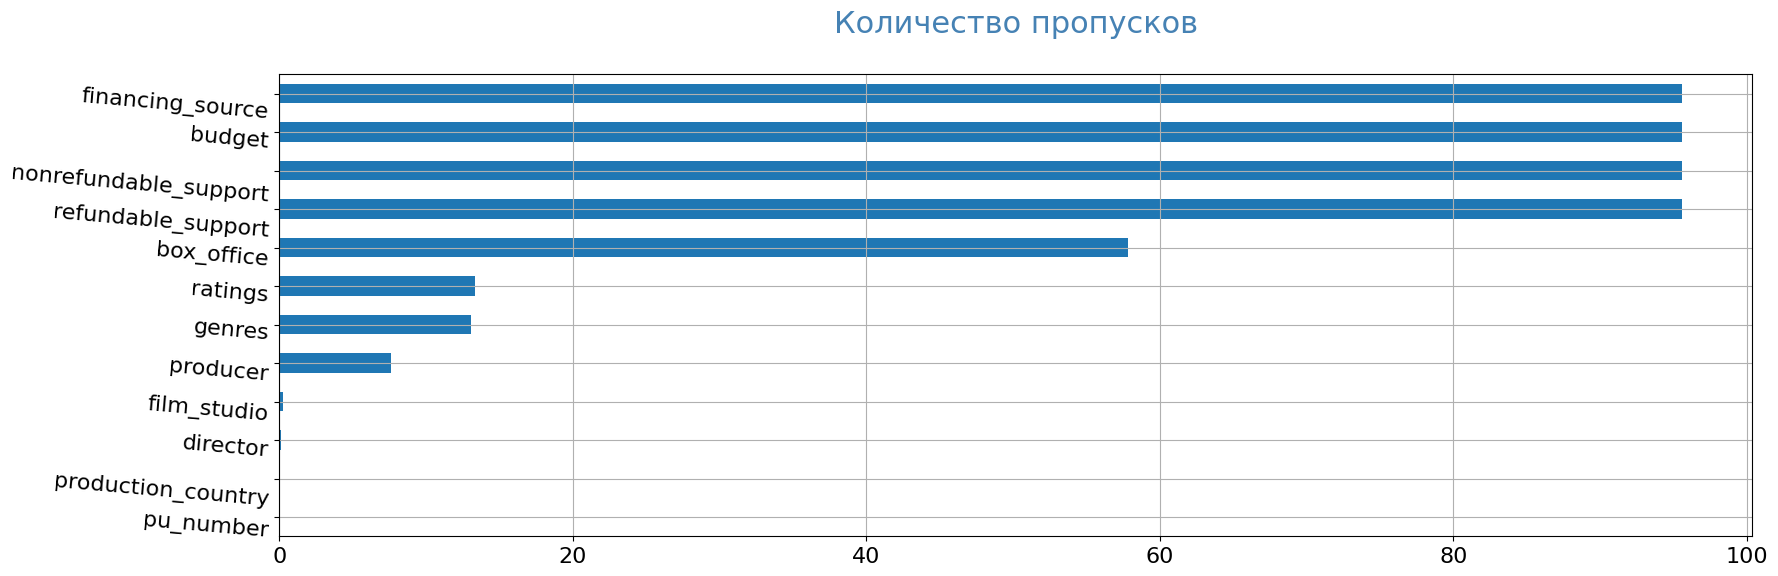

In [16]:
pass_value_barh(df, "Количество пропусков")

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br /> Наглядность представления информации одна из важных составляющих работы дата-аналитика или дата-сайентиста
    
__мой график оформлен не совсем корректно, сможешь отметить, что стоило бы исправить в графике?__
  

<div class="alert alert-info">
<font size="4", color = "black">Благодарю за отличный пример визуализации. Возьму себе в копилку. На мой взгляд название графика можно вынести в переменную функции, также добавить сетку для упрощения сопоставления точек на графике со значениями.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

Посмотрим на фильм без номера прокатного удостоверения `pu_number` чтобы принять решение о полезности этой записи.

In [17]:
df[df["pu_number"].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1797,Курбан-роман. (История с жертвой),<NA>,2014-05-15,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку эта запись не содержит полезной для целий аналитики данных, избавимся от неё.

In [18]:
df = df[df["pu_number"].notna()]

Пропуски в поле со студией-производителем `film_studio` фильма не влияют на цели анализа и не могут быть алгоритмически заполнены, поэтому оставим их.

Рассмотрим фильмы с пропуском в стране производства `production_country`.

In [19]:
df[df["production_country"].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",0,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25,Художественный,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


In [20]:
df["production_country"].unique()

['США', 'СССР', 'Франция', 'СССР, Венгрия', 'Германия-Великобритания', ..., 'КНР - Франция', 'Дания, Норвегия, Швеция, Исландия', 'Республика Кипр, США, Россия', 'Новая Зеландия - КНР', 'Дания - Канада - Швеция - Франция - Германия ...]
Length: 951
Categories (950, object): ['США', 'СССР', 'Франция', 'СССР, Венгрия', ..., 'Дания, Норвегия, Швеция, Исландия', 'Республика Кипр, США, Россия', 'Новая Зеландия - КНР', 'Дания - Канада - Швеция - Франция - Германия ...]

Заполним пропуски вручную т.к. понятно, что страна производства этих фильмов - РФ.

In [21]:
df.loc[df["production_country"].isna(), "production_country"] = "Россия"

Заполним пропуски в поле `director` вручную воспользовавшись поиском.

In [22]:
df[df["director"].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,0,NaN,NaN,NaN,NaN,NaN,NaN,44350.0
1735,Помпеи. Британский музей,126003413,2013-09-11,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,0,NaN,NaN,NaN,NaN,7.9,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25,Художественный,NaN,Россия,NaN,NaN,0,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,0,NaN,NaN,NaN,NaN,6.7,"концерт,музыка",NaN


Поиск информации о режессёрах этих фильмов не дал результатов, поэтому оставим пропуски как есть.

Оставшиеся поля с пропусками не подлежат алгоритмическому заполнению. В случае с рейтингами или жанрами фильмов, их просто нет на площадке. Отсутствующая информация о финансировании означает, что проект не субсидировался.

### Обработаем дубликаты

Проверим наличие явных дубликатов.

In [23]:
df.duplicated().sum()

0

In [24]:
df.duplicated(["title", "pu_number"]).sum()

0

Удалим дубликаты, которые отличаются случайными символами.

In [25]:
df["title"] = df["title"].str.strip("._- ")
df["title"] = df["title"].str.replace('ё', 'e')
df["title"] = df["title"].str.lower()

In [26]:
df = df.drop_duplicates(["title", "pu_number"])

Воспользуемся расстоянием Левенштайна между строками чтобы найти неявные дубликаты т.к. уникальных значений достаточно много чтобы обрабатывать их вручную и достаочно мало, чтобы алгоритм сработал за относительно непродолжительное время. 

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Стоит подумать над оптимизацией алгоритма, чтобы уменьшить время выполнения, один из самых простых примеров

In [27]:
df["title"].nunique()

6655

In [28]:
print(pd.Timestamp.now())

2024-11-07 01:09:23.276676


In [29]:
for i in df["title"].unique():
    df.loc[df['title'] == i, 'title_len'] = df.loc[df['title'] == i, 'title'].str.len()

In [30]:
print(pd.Timestamp.now())

2024-11-07 01:09:35.055219


In [31]:
df['title_len'] = df['title_len'].astype(int)

In [32]:
def print_duplicates_len(strings, len_strings, dist):
    duplicates_count = 0

    for i in range(0, len(strings)):
        for j in range(i, len(strings)):
            
            if abs(len_strings[i] - len_strings[j]) <= 1:
                
                if i == j: continue

                if distance(strings.iloc[i], strings.iloc[j]) <= dist:
                    print(f"{i}: {strings.iloc[i]} \t{j}: {strings.iloc[j]}")
                    duplicates_count += 1
                        
            else: continue
            
    print(f"Duplicates count: {duplicates_count}")

In [33]:
print(pd.Timestamp.now())

2024-11-07 01:09:35.102813


In [34]:
df = df.reset_index()

Исследуем названия фильмов с одним отличием.

In [35]:
print_duplicates_len(df[df["title"].isin(df['title'].unique())]['title'], df["title_len"], 1)

Удалим временную колонку, созданную для оптимизации поиска дубликатов.

In [36]:
df = df.drop(columns=["title_len"])

In [37]:
print(pd.Timestamp.now())

2024-11-07 01:09:35.164809


<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Скоратил время выполнения примерно на 1 минуту 30 сек.

<div class="alert alert-info">
<font size="4", color = "black">Благодарю за дельное предложение. Фильтруем сразу по длине строк те комбинации, для которых этот жадный алгоритм будет тратить много дополнительного времени, круто.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

Проверим по индексам похожие на неявные дубликаты записи.

In [38]:
df.iloc[[738, 2053, 762, 1360, 937, 3560, 1581, 4427, 1737, 2467, 2375, 3983, 2392, 5727, 2448, 4176, 2838, 2866, 2866, 4735, 3203, 3918, 3940, 6380, 4076, 4429, 5894, 5957]]

,index,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
738,738,обливион,121004513,2013-02-21,Художественный,"Чернин Интертейнмент, Айрохед Студиос, Радикал...",США,Джозеф Косински,"Дилан Кларк, Джозеф Косински, Дункан Хендерсон",12,NaN,NaN,NaN,NaN,7.2,"фантастика,боевик,триллер",300.00
2053,2054,мать мария,111025314,2014-12-24,Художественный,"Киностудия ""Мосфильм""",СССР,С.Колосов,NaN,12,NaN,NaN,NaN,NaN,6.6,"драма,биография",NaN
762,762,вишенка на новогоднем торте,121030512,2012-12-17,Художественный,"Мэзон до Синема, Судэн Компани, Нат/Болт Прода...",Франция,Лаура Моранте,"Франческо Джиамматтео, Бруно Песери",16,NaN,NaN,NaN,NaN,5.8,комедия,NaN
1360,1360,жорж бизе. кармен /по мотивам одноименной нове...,126003113,2013-09-03,Прочие,Синема Лайв,Австралия,"Брайан Томсон, Гейл Эдвардс",NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,937,волшебная страна,124001113,2013-04-15,Анимационный,"Брейктру Филмз, Эс Эм Бэ Инвестментс",Великобритания - Польша - КНР - Индия - Норвегия,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси","Магдалена Баргел, Хью Велчман",18,NaN,NaN,NaN,NaN,7.9,"драма,семейный,биография",20260.00
3560,3561,поезд в пусан,121030816,2016-11-17,Художественный,Контентс Панда,Южная Корея,Ён Сан-хо,"Ли Дон-ха, Ким Ён-хо",18,NaN,NaN,NaN,NaN,7.1,"ужасы,боевик,триллер",8459304.83
1581,1581,другая женщина,121006814,2014-04-09,Художественный,"Эл Би И Продакшнз, ХХ век Фокс",США,Ник Кассаветис,"Дональд Дж.Ли младший, Чак Пачеко, Джули Силве...",16,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN
4427,4428,гарри поттер и принц-полукровка /по роману дж....,221134610,2010-11-29,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,Дэйвид Хейман,12,NaN,NaN,NaN,NaN,7.7,"фэнтези,приключения,семейный",NaN
1737,1737,как поймать перо жар-птицы,114000513,2013-10-11,Художественный,"ООО ""Визарт Фильм"", ООО ""Кинокомпания ""СТВ""",Россия,"В.Плотников, Г.Гитис","С.Сельянов, А.Лигай, С.Рапопорт, Ю.Москвин",0,NaN,NaN,NaN,NaN,5.2,"мультфильм,фэнтези",96846.00
2467,2468,весь этот джем,111016515,2015-09-17,Художественный,"ООО ""Кинокомпания ""Спутник""",Россия,А.Адраникян,"А.Адраникян, В.Горяинов",16,NaN,NaN,NaN,NaN,5.0,"мелодрама,комедия",NaN


На основании ручного анализа схожих записей удалим неявные дубликаты. 

In [39]:
df = df.loc[df.index.drop([2745, 4698, 3194, 4366, 5068])]

In [40]:
df.duplicated(["title", "pu_number"]).sum()

0

In [41]:
# check
df[df.duplicated(subset=['title', 'director'], keep=False)==True].sort_values('title')[['title', 
    'show_start_date','director', 'refundable_support', 'nonrefundable_support', 'budget',
         'ratings', 'genres', 'box_office']]

,title,show_start_date,director,refundable_support,nonrefundable_support,budget,ratings,genres,box_office
779,10 лет спустя,2013-01-15,Джеми Линден,NaN,NaN,NaN,6.0,"драма,мелодрама,комедия",NaN
778,10 лет спустя,2012-12-13,Джеми Линден,NaN,NaN,NaN,6.0,"драма,мелодрама,комедия",NaN
454,100 миллионов евро,2016-05-25,Оливер Барру,NaN,NaN,NaN,6.1,комедия,NaN
455,100 миллионов евро,2012-06-06,Оливер Барру,NaN,NaN,NaN,6.1,комедия,NaN
4851,127 часов,2011-01-27,Дэнни Бойл,NaN,NaN,NaN,7.7,"триллер,биография,драма",NaN
...,...,...,...,...,...,...,...,...,...
4504,я ненавижу день святого валентина,2010-12-03,Ниа Вардалос,NaN,NaN,NaN,5.0,"мелодрама,комедия",NaN
1703,"я, снова я и мама",2016-05-23,Гийом Гальенн,NaN,NaN,NaN,6.3,"комедия,мелодрама,драма",NaN
1704,"я, снова я и мама",2013-11-21,Гийом Гальенн,NaN,NaN,NaN,6.3,"комедия,мелодрама,драма",NaN
6378,ян антонышев,2018-11-15,Е.Окопная,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df = df.drop_duplicates(['title', 'director'])

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит обработать и такие дубликаты ⬆⬆

<div class="alert alert-info">
<font size="4", color = "black">Сделано. На будущее нужно быть внимательнее в поиске комбинаций, дающих уникальные значения.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

Изучим категориальные поля. Удалим лишние символы в начале и конце всех строк с категориальными значениями.

In [43]:
df["type"] = df["type"].str.strip('._- ')
df["type"].value_counts()

Художественный                5278
Анимационный                   768
Прочие                         391
Документальный                 276
Научно-популярный               52
Музыкально-развлекательный       1
Name: type, dtype: int64

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> От лишних пробелов избавились корректно, молодец
        
        

In [44]:
df["film_studio"] = df["film_studio"].str.strip('._- ')
df["film_studio"].value_counts()

Киностудия "Мосфильм"                                                                                                                                               341
ООО "Мульт в кино"                                                                                                                                                   75
Анимаккорд Лтд                                                                                                                                                       27
ООО "ТаББаК"                                                                                                                                                         18
ФГУП "ТПО "Киностудия "Союзмультфильм"                                                                                                                               16
                                                                                                                                                                

In [45]:
df["production_country"] = df["production_country"].str.strip('._- ')
df["production_country"].value_counts()

Россия                              1805
США                                 1766
СССР                                 373
Франция                              277
Великобритания                       241
                                    ... 
Мексика - Тайвань - США                1
Армения - Германия                     1
Франция - Италия - Бельгия - КНР       1
Австрия-Германия-Франция               1
США - Великобритания - Ирландия        1
Name: production_country, Length: 929, dtype: int64

In [46]:
df["director"] = df["director"].str.strip('._- ')
df["director"].value_counts()

О.Семёнова                                           60
Д.Червяцов                                           16
Вуди Аллен                                           13
Стивен Содерберг                                     12
П.Смирнов                                            11
                                                     ..
А.Новиков (псевдоним - Александр Новиков-Янгинов)     1
Сэмюэл Байер                                          1
Ник Мерфи                                             1
М.Кумыков                                             1
Фернандо Труэбо                                       1
Name: director, Length: 4797, dtype: int64

In [47]:
df["producer"] = df["producer"].str.strip('._- ')
df["producer"].value_counts()

П.Смирнов                                                                   67
Олег Кузовков, Дмитрий Ловейко, Марина Ратина                               28
С.Сельянов                                                                  18
Д.Ловейко, О.Кузовков                                                       16
А.Тельнов                                                                   12
                                                                            ..
С.Ливнев, Г.Малков, Д.Захаров, П.Федоров, С.Дандурян, В.Трошин, П.Бардин     1
Николас Альтмайер, Эрик Альтмайер, Давид Рагониг                             1
Жорж Берманн, Фредерик Нидермайер                                            1
Тим Бивен, Лайза Чейзин, Эрик Феллнер, Стив Голин, Майкл Шугар               1
Гаймон Кеседи, Росс М. Динерштейн, Бенджамин Форкнер, Гас Кригер             1
Name: producer, Length: 5314, dtype: int64

In [48]:
df["genres"] = df["genres"].str.strip('._- ')
df["genres"].value_counts()

драма                           453
комедия                         330
мелодрама,комедия               180
драма,мелодрама                 170
драма,мелодрама,комедия         164
                               ... 
драма,фантастика,ужасы            1
мультфильм,боевик,детектив        1
семейный,приключения,военный      1
криминал,комедия                  1
для взрослых,драма,мелодрама      1
Name: genres, Length: 741, dtype: int64

Некоторые их категориальных данных хранят вложенные списки. Преобразуем такие поля в тип массивов значений.

In [49]:
df["film_studio"] = df["film_studio"].str.split(',')
df["production_country"] = df["production_country"].str.split(',')
df["director"] = df["director"].str.split(',')
df["producer"] = df["producer"].str.split(',')
df["genres"] = df["genres"].str.split(',')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6766 entries, 0 to 7484
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   index                  6766 non-null   int64   
 1   title                  6766 non-null   object  
 2   pu_number              6766 non-null   UInt32  
 3   show_start_date        6766 non-null   category
 4   type                   6766 non-null   object  
 5   film_studio            6749 non-null   object  
 6   production_country     6766 non-null   object  
 7   director               6757 non-null   object  
 8   producer               6210 non-null   object  
 9   age_restriction        6766 non-null   uint8   
 10  refundable_support     330 non-null    float64 
 11  nonrefundable_support  330 non-null    float64 
 12  budget                 330 non-null    float64 
 13  financing_source       330 non-null    category
 14  ratings                5780 non-null   f

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит определить основную проблему в колонках с категориальными данными  

<div class="alert alert-info">
<font size="4", color = "black">Проблема заключается в том, что в данных есть вложенная структура, которую сделали плоской собрав значения в строку с разделителем из запятых Преобразовал к экспериментальному типу данных Pandas pandas.arrays.StringArray.</font>
    <br /> 
    <font size="3", color = "black">
<br />      
        

Обновим индекс после чистки данных.

In [51]:
df = df.reset_index(drop=True)

Изучим столбцы с количественными значениями.

No handles with labels found to put in legend.


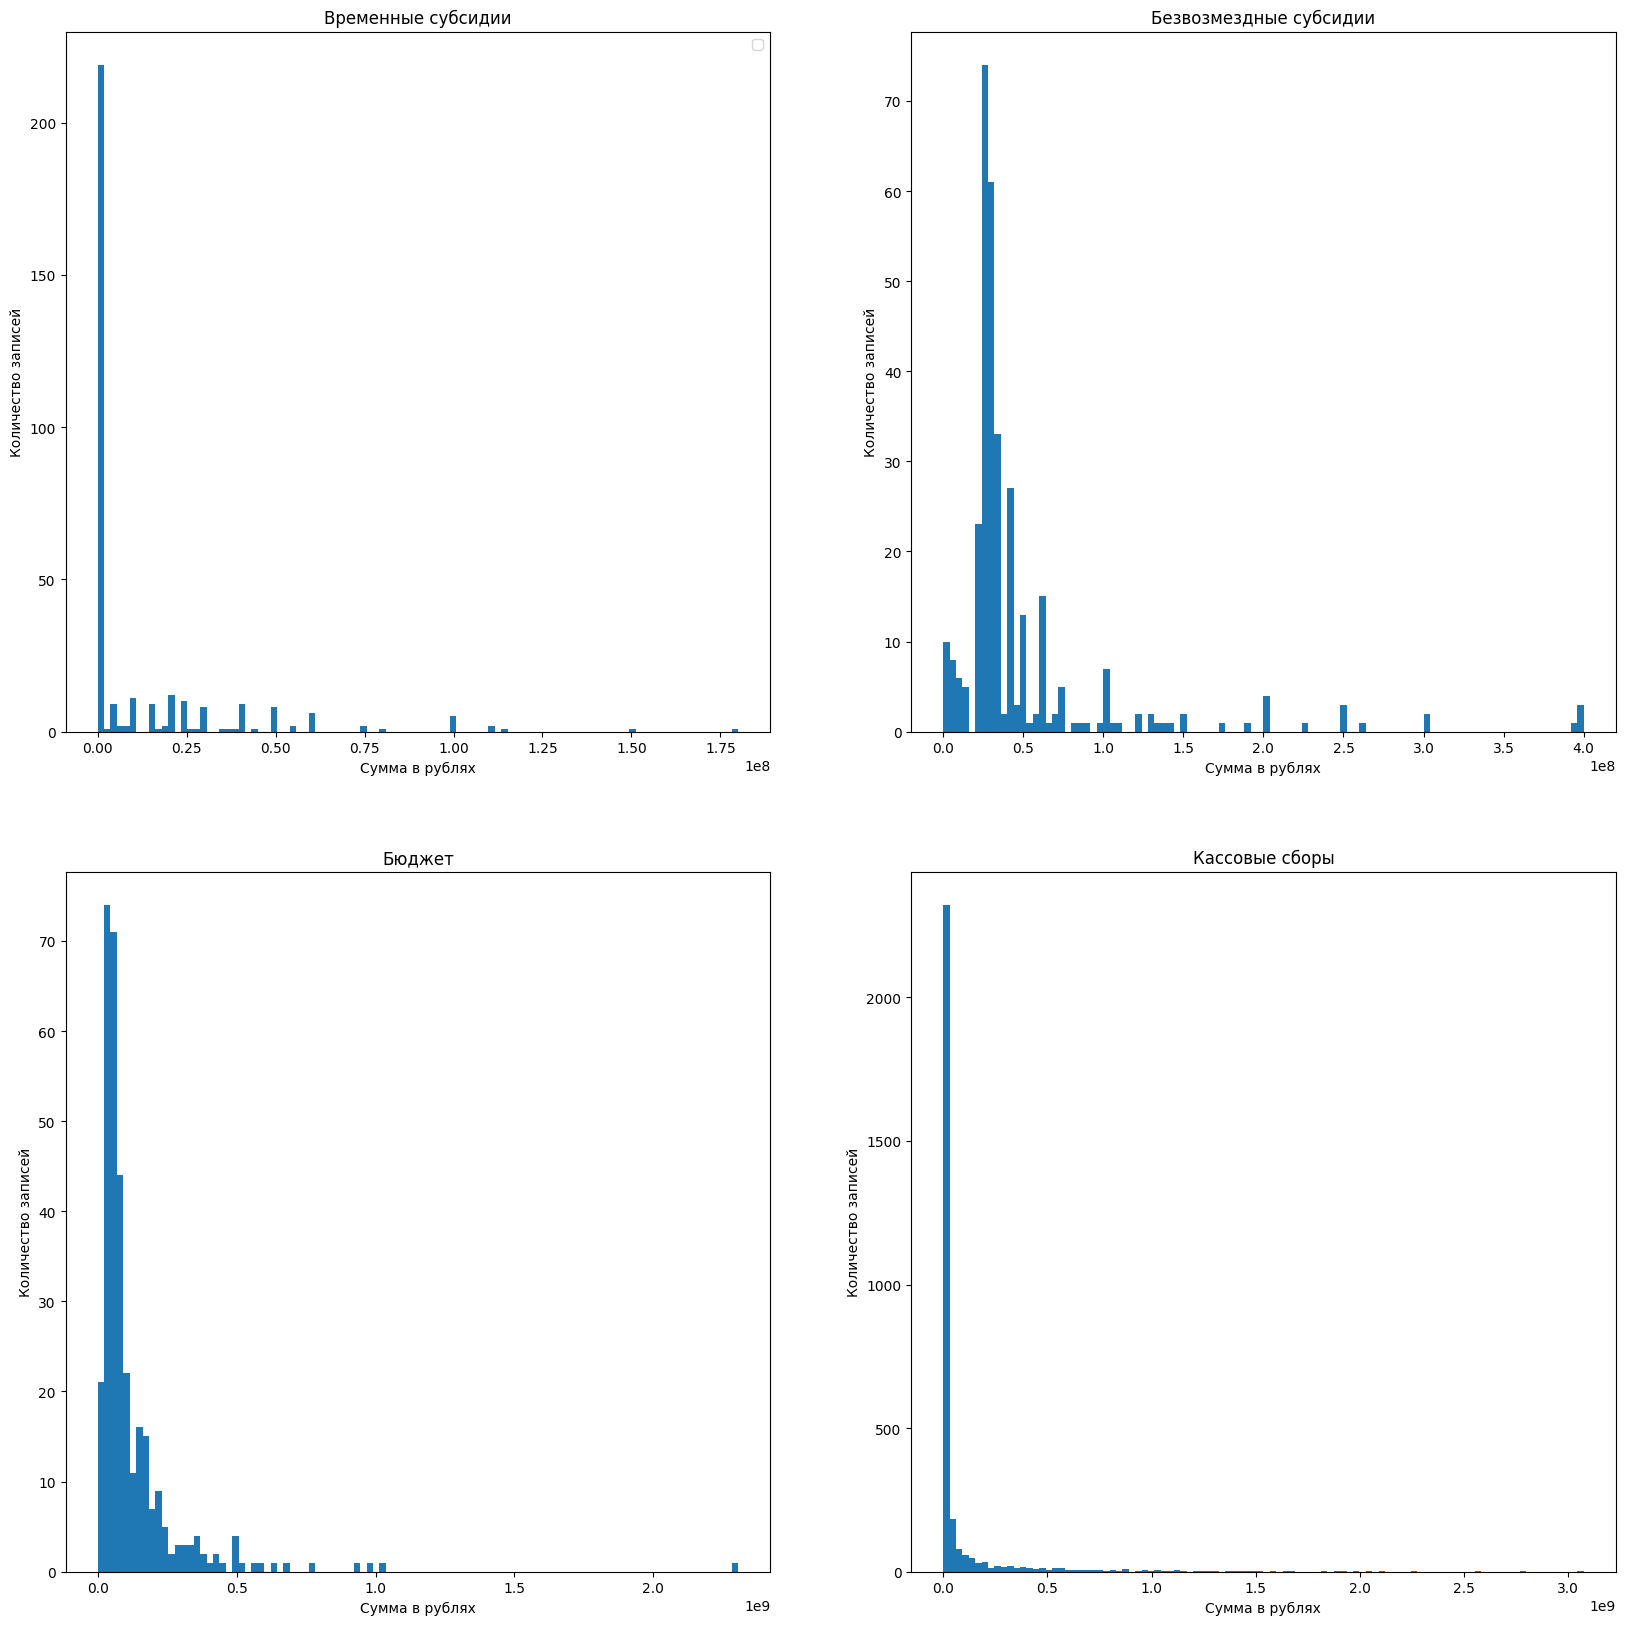

In [52]:
numeric = df.select_dtypes(include=['float', 'int'])

def quantitative_hist(df):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize =(20, 20))

    ax0.hist(df["refundable_support"], 100, histtype='bar')
    ax0.legend(prop={'size': 10})
    ax0.set_title('Временные субсидии')
    ax0.set_xlabel('Сумма в рублях')
    ax0.set_ylabel('Количество записей')

    ax1.hist(df["nonrefundable_support"], 100, histtype='bar')
    ax1.set_title('Безвозмездные субсидии')
    ax1.set_xlabel('Сумма в рублях')
    ax1.set_ylabel('Количество записей')

    ax2.hist(df["budget"], 100, histtype='bar')
    ax2.set_title('Бюджет')
    ax2.set_xlabel('Сумма в рублях')
    ax2.set_ylabel('Количество записей')

    ax3.hist(df["box_office"], 100, histtype='bar')
    ax3.set_title('Кассовые сборы')
    ax3.set_xlabel('Сумма в рублях')
    ax3.set_ylabel('Количество записей')

    plt.show();

quantitative_hist(numeric)

Явно видно что бюджеты субсидий большинства фильмов сосредоточены в достаточно узком диапазоне. Рассмотрим каждое из полей подробнее используя wiskers.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит полностью оформить все графики на проекте

Подписи осей на графиках и название добавят ясности и читабельности.
Это важные элементы любой визуализации. Как добавить подписи и названия, смотри [здесь](https://proproprogs.ru/modules/matplotlib-razmeshchaem-standartnye-tekstovye-elementy-na-grafike?ysclid=l6agtioc6f299002507)

<div class="alert alert-info">
<font size="4", color = "black">Добавил метаданные на графики.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

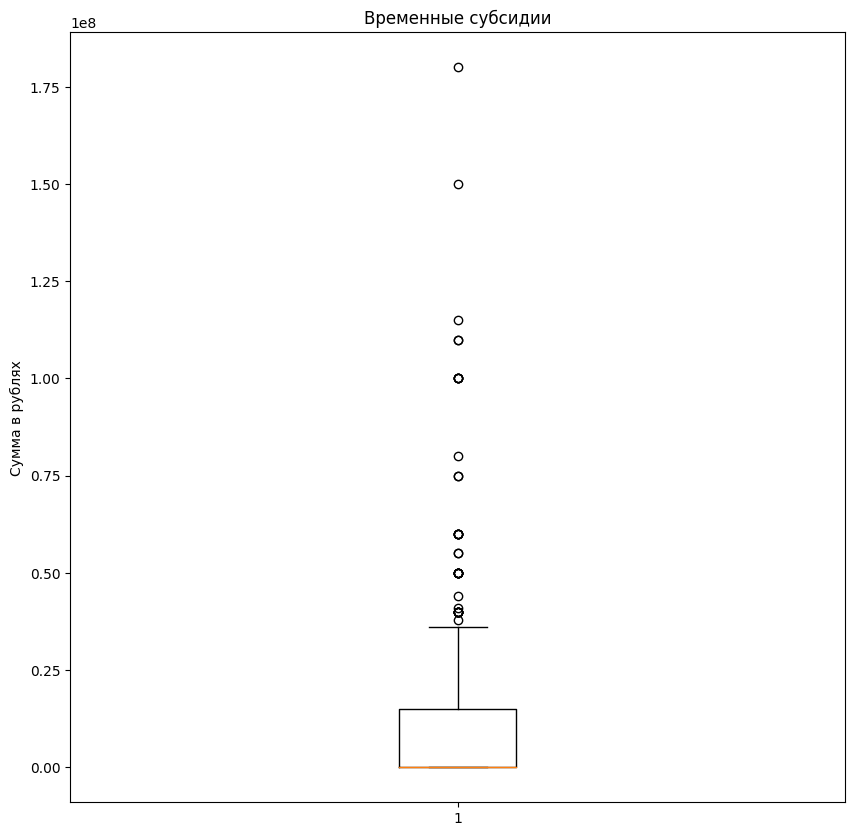

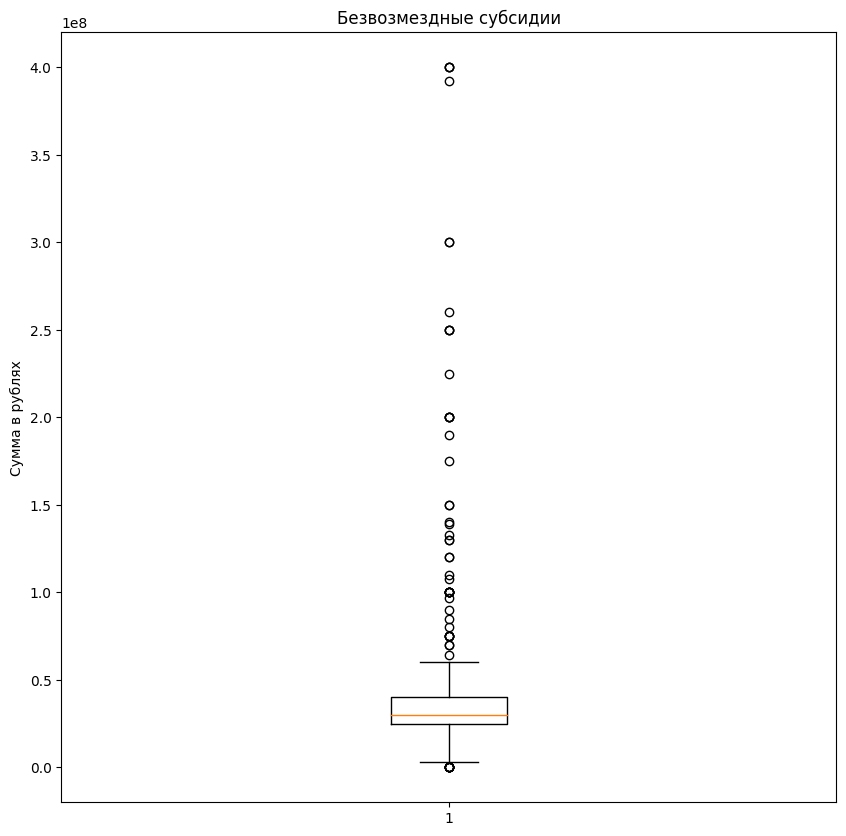

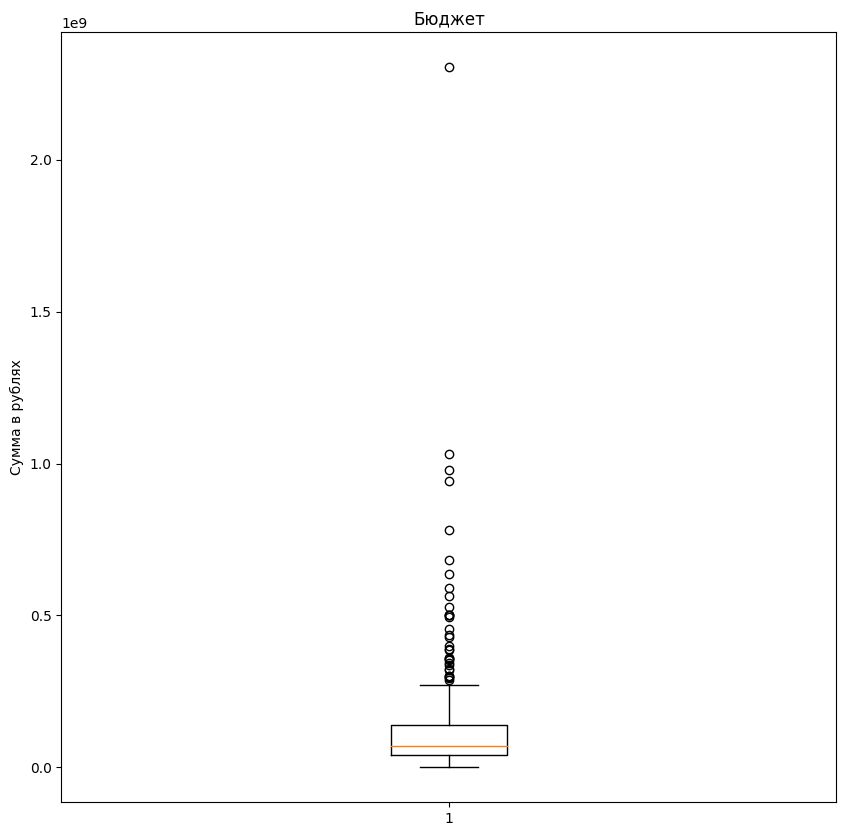

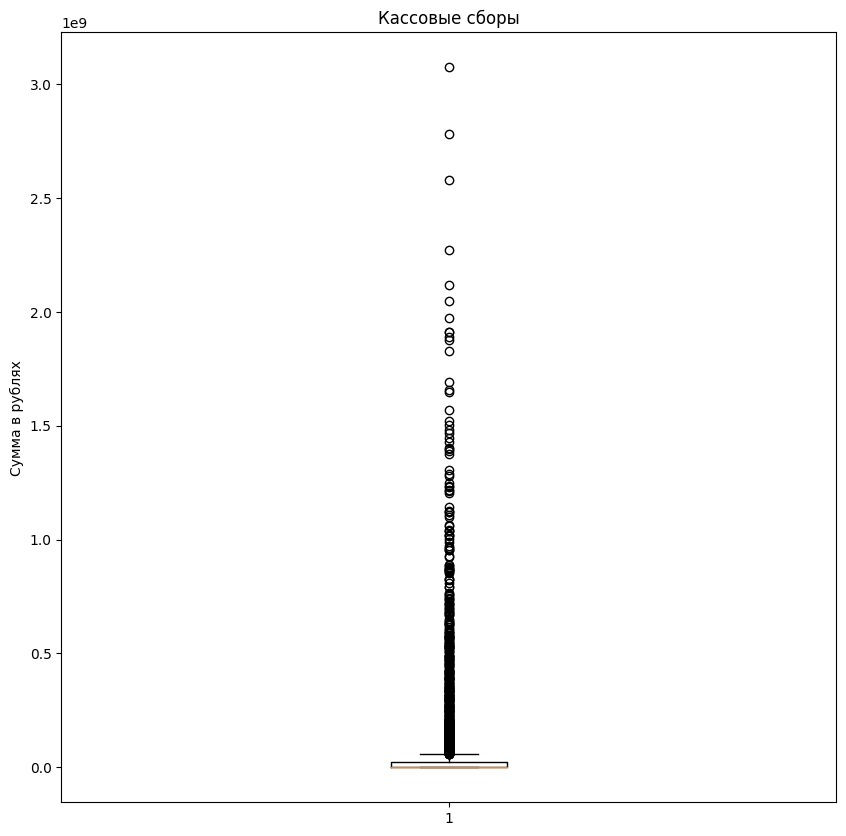

In [53]:
def show_quantitative():
    titles = ["Временные субсидии", "Безвозмездные субсидии", "Бюджет", "Кассовые сборы"]

    for i in range(0, len(numeric.columns)):
        fig, ax = plt.subplots(figsize =(10, 10))
        ax.boxplot(df.loc[df[numeric.columns[i]].notna(), numeric.columns[i]]);
        ax.set_title(titles[i])
        ax.set_ylabel('Сумма в рублях')
        plt.show()

show_quantitative()

Заметим, что проекты с безвозмездной поддержкой получают большие, чем остальные, субсидии. Отмасштабируем остальные финансовые поля.

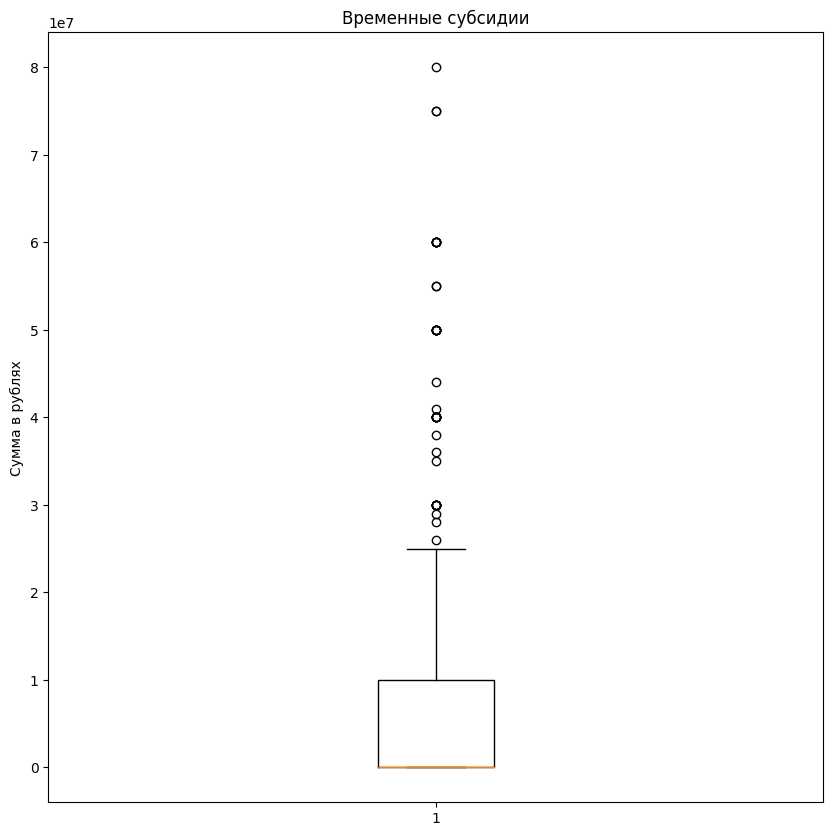

In [54]:
fig, ax = plt.subplots(figsize =(10, 10))
ax.boxplot(df.loc[(df["refundable_support"].notna()) & (df["refundable_support"] < 100_000_000), "refundable_support"])
ax.set_title("Временные субсидии")
ax.set_ylabel('Сумма в рублях')
plt.show()

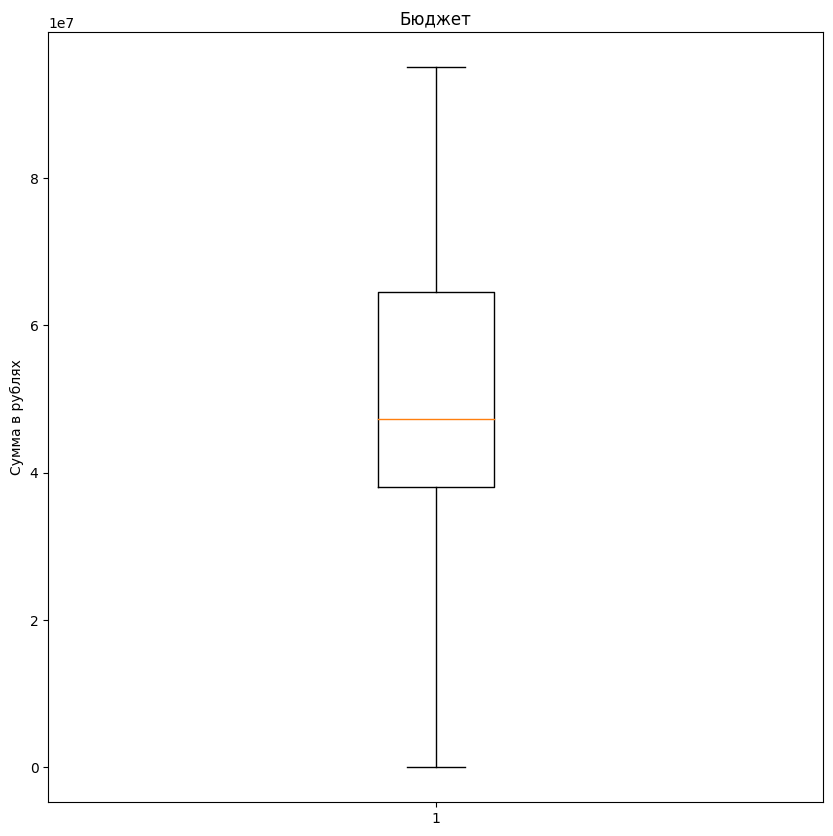

In [55]:
fig, ax = plt.subplots(figsize =(10, 10))
ax.boxplot(df.loc[(df["budget"].notna()) & (df["budget"] < 100_000_000), "budget"])
ax.set_title("Бюджет")
ax.set_ylabel('Сумма в рублях')
plt.show()

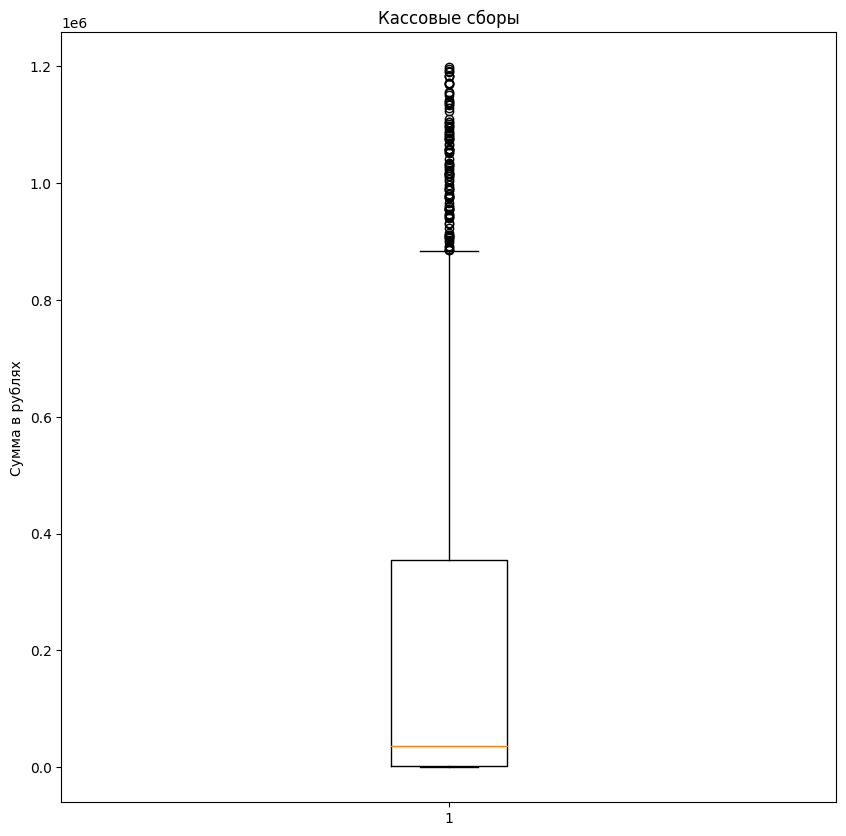

In [56]:
fig, ax = plt.subplots(figsize =(10, 10))
ax.boxplot(df.loc[(df["box_office"].notna()) & (df["box_office"] < 1_200_000), "box_office"])
ax.set_title("Кассовые сборы")
ax.set_ylabel('Сумма в рублях')
plt.show()

Кажется, что данные искажены нулевыми значениями. Проверим описательную статистику.

In [57]:
for col in numeric.columns:
    print(df[col].describe(), '\n')

count    3.300000e+02
mean     1.193636e+07
std      2.497495e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.500000e+07
max      1.800000e+08
Name: refundable_support, dtype: float64 

count    3.300000e+02
mean     4.891421e+07
std      6.011049e+07
min      0.000000e+00
25%      2.500000e+07
50%      3.000000e+07
75%      4.000000e+07
max      4.000000e+08
Name: nonrefundable_support, dtype: float64 

count    3.300000e+02
mean     1.270454e+08
std      1.889524e+08
min      0.000000e+00
25%      4.200000e+07
50%      6.864992e+07
75%      1.400201e+08
max      2.305074e+09
Name: budget, dtype: float64 

count    3.015000e+03
mean     7.561558e+07
std      2.377736e+08
min      0.000000e+00
25%      1.241840e+05
50%      2.441370e+06
75%      2.366786e+07
max      3.073569e+09
Name: box_office, dtype: float64 



Заменим на None нулевые значения, чтобы анализировать только субсидируемые картины. 

In [58]:
for col in numeric.columns:
    print(f"Количество нулевых значений в колонке {col}: {(df[col] == 0).sum()}")
    df[col] = df[col].replace(0, np.nan)

Количество нулевых значений в колонке refundable_support: 219
Количество нулевых значений в колонке nonrefundable_support: 9
Количество нулевых значений в колонке budget: 17
Количество нулевых значений в колонке box_office: 24


Рассмотрим графики ещё раз после замены.

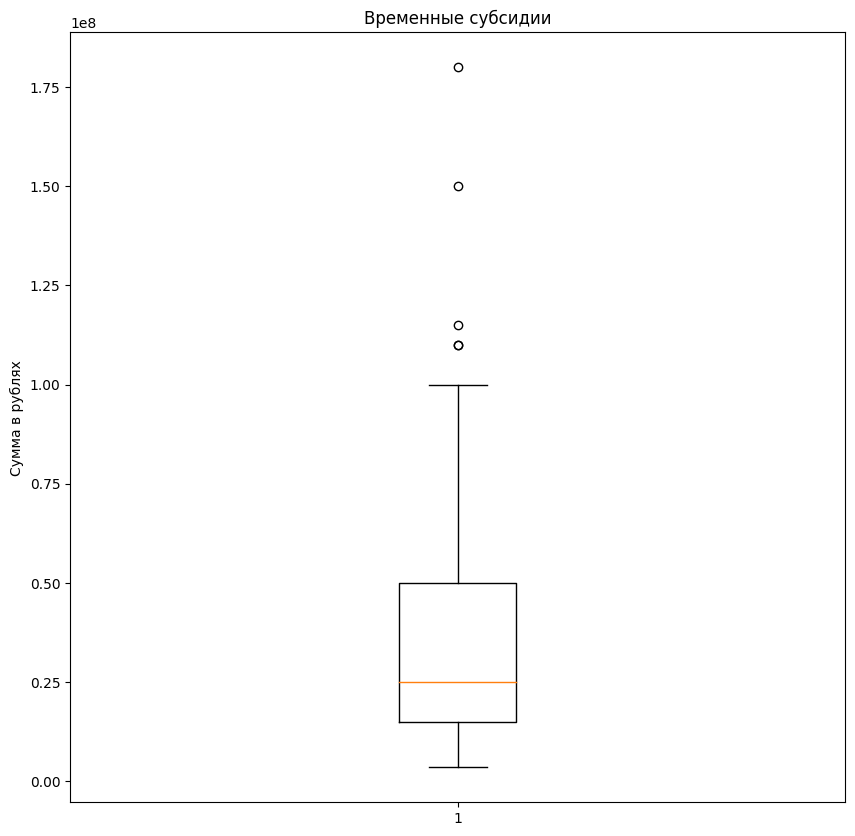

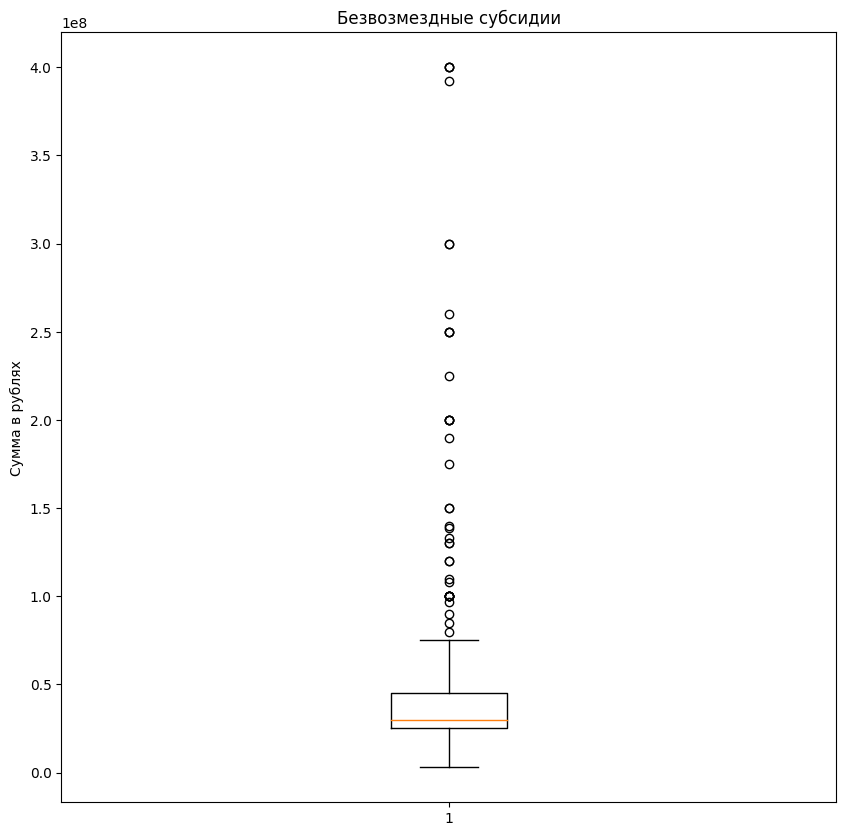

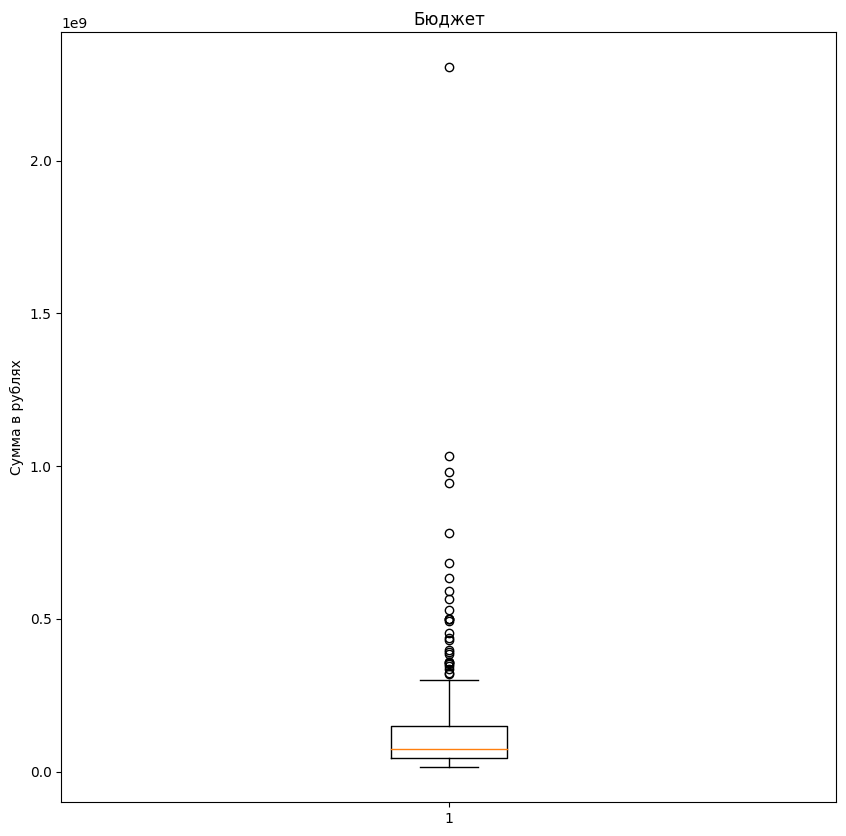

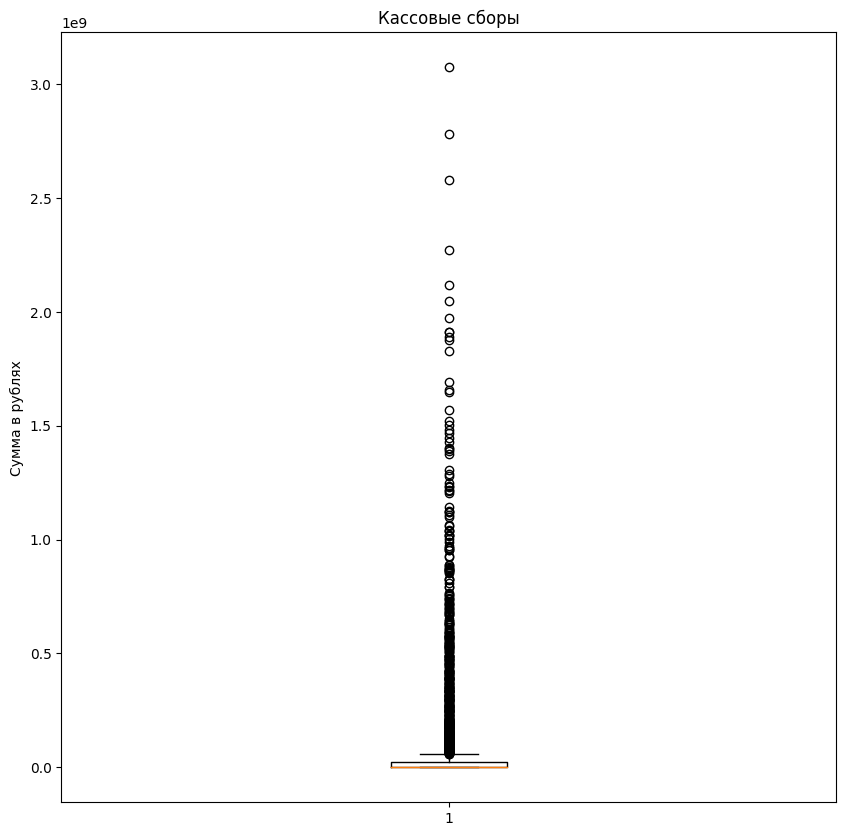

In [59]:
show_quantitative()

No handles with labels found to put in legend.


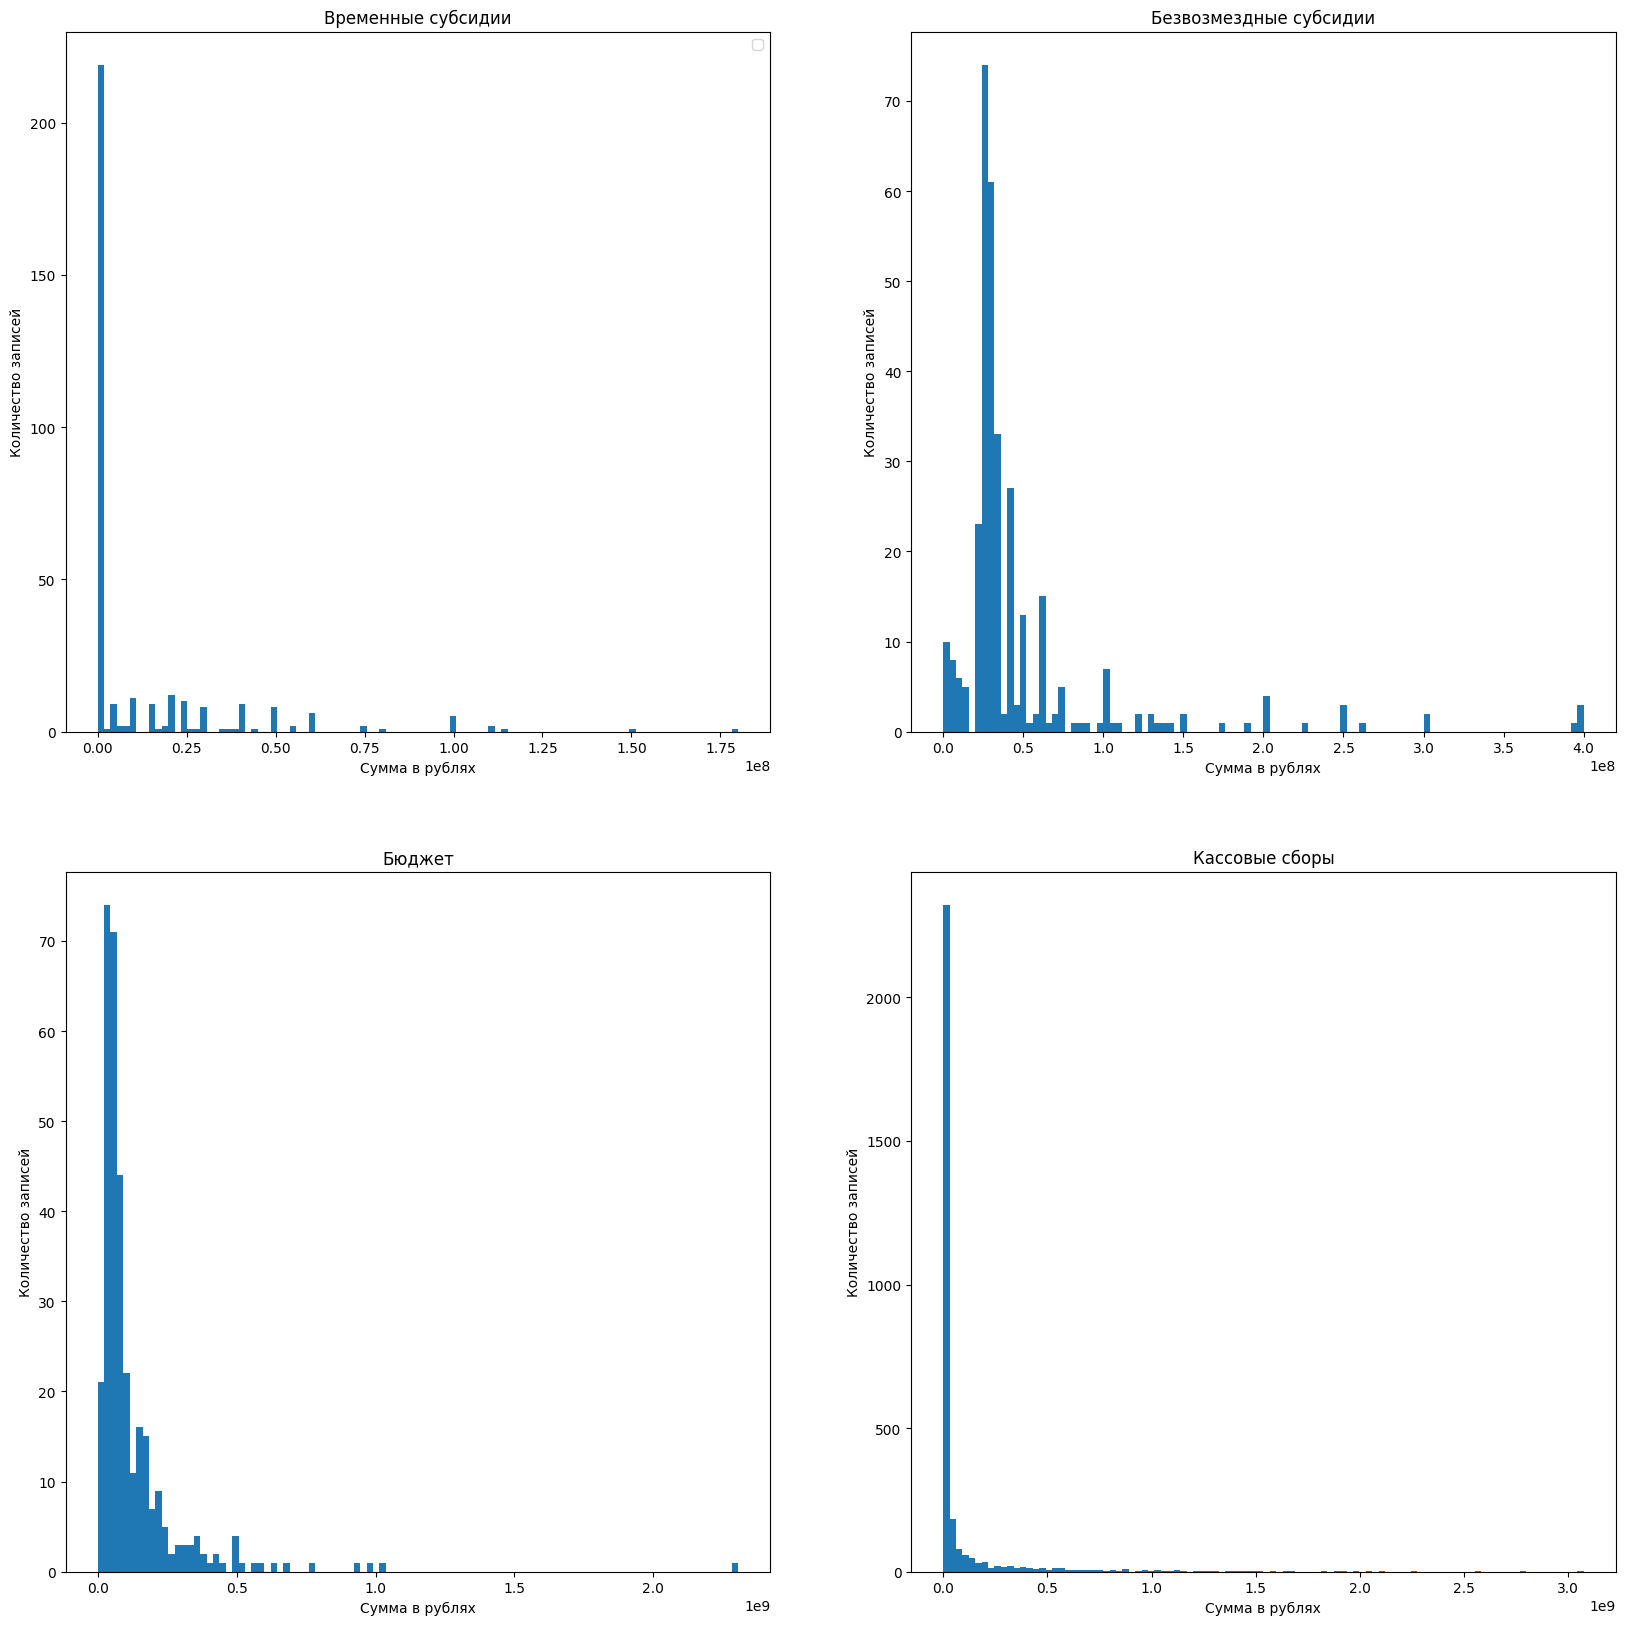

In [60]:
quantitative_hist(numeric)

Наблюдаем финансовую статистику с длинными хвостами. Учитывая цели исследования по нахождению трендов заметим, что выбросами можно считать значения более 100_000_000 для `refundable_support`, 75_000_000 для `nonrefundable_support`, 250_000_000 для `budget` и 40_000_000 для `box_office`. Удалять их не будем т.к. в данном иссоедовании подобные фильмы составляют интерес для анализа.

Исследуем фильмы таже с относительно малыми бюджетами более 0 , но менее 100_000_000 рублей.

No handles with labels found to put in legend.


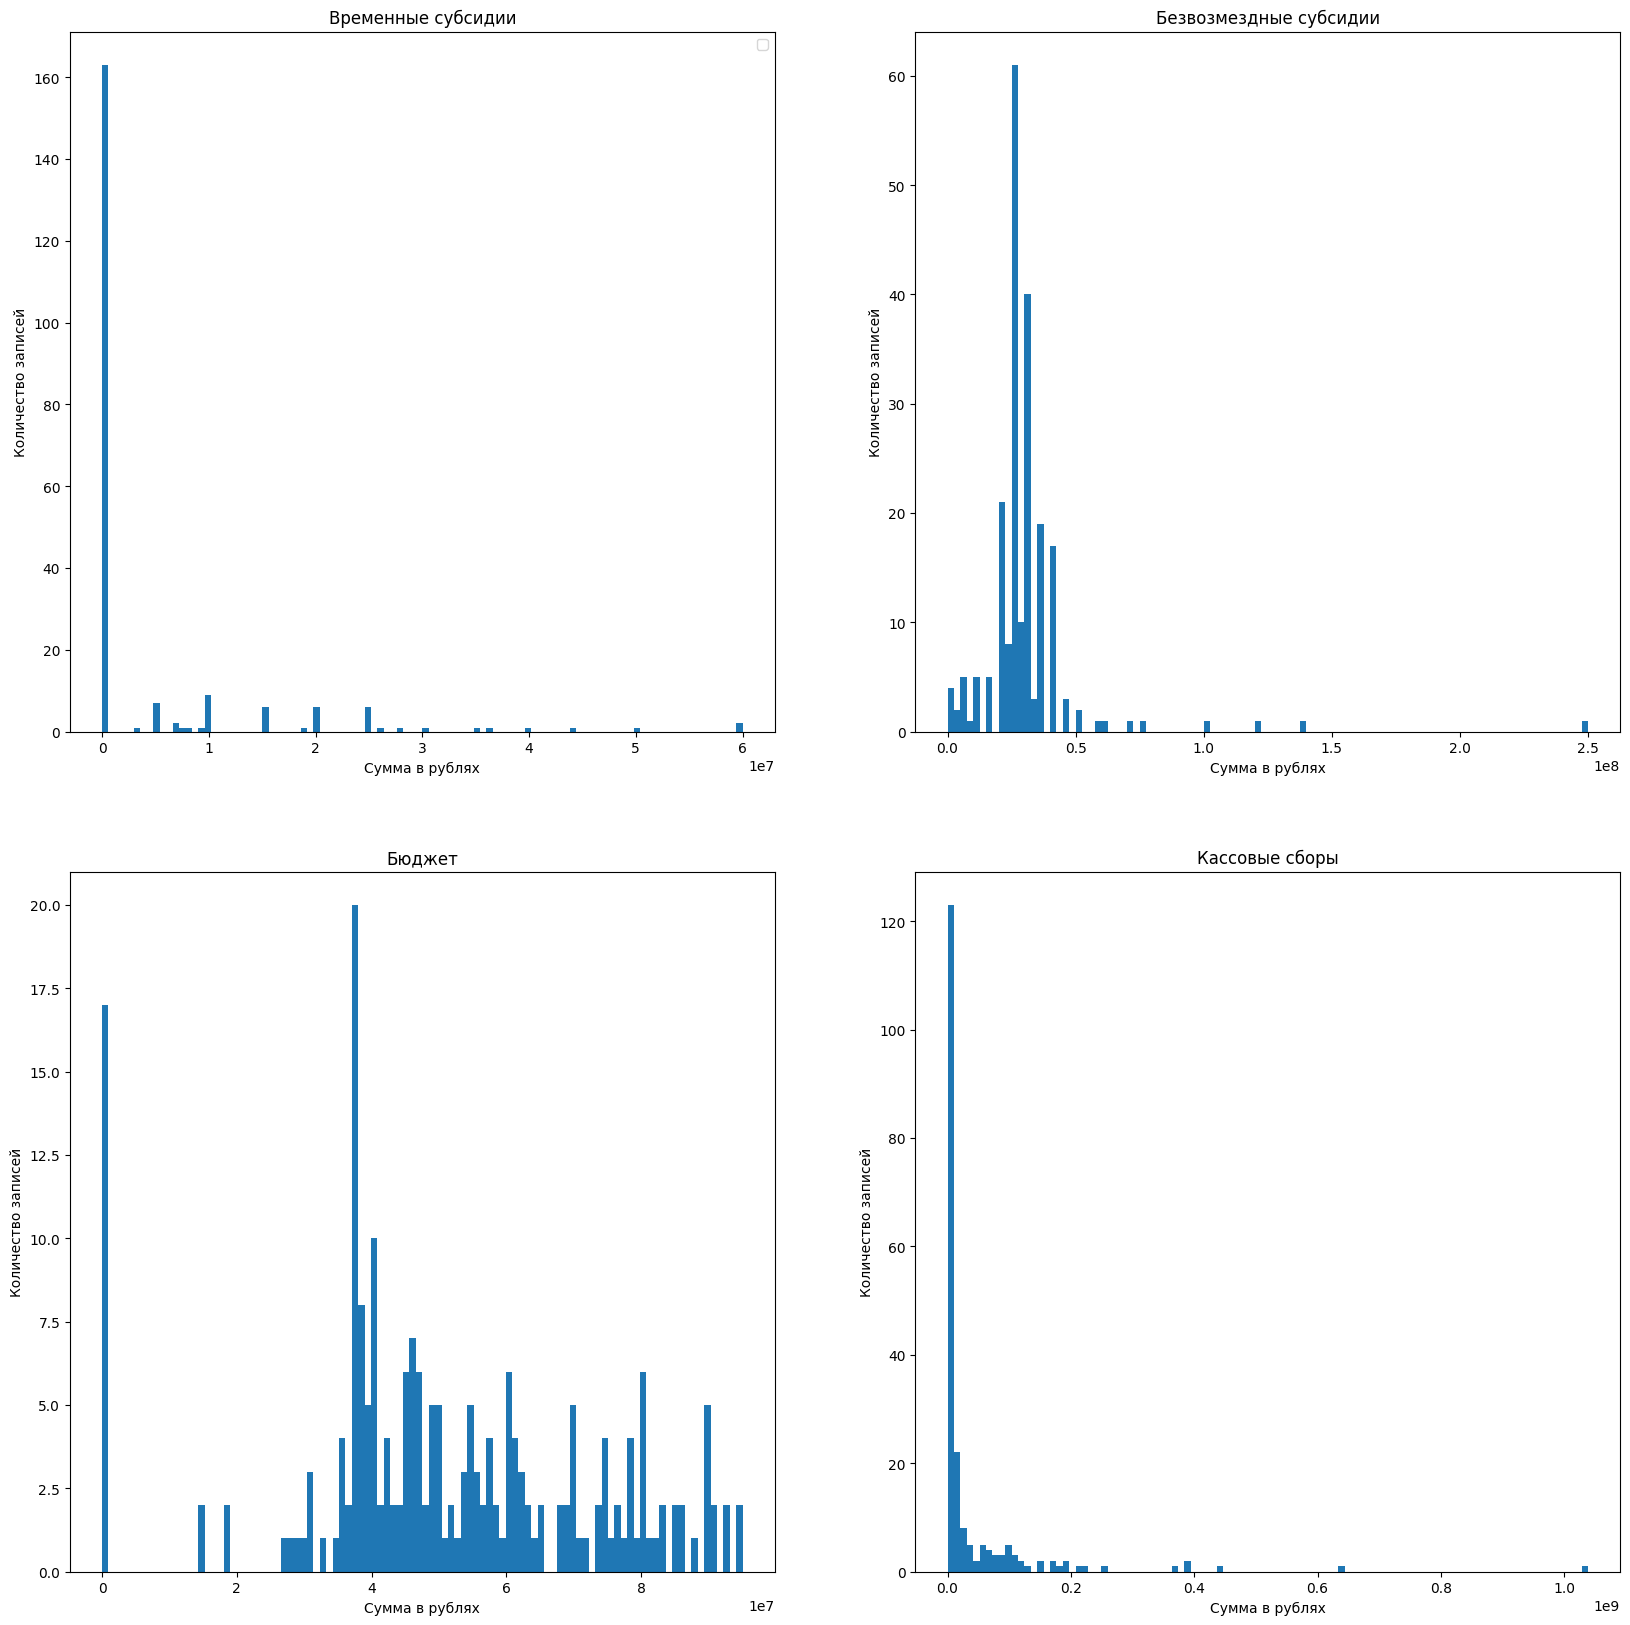

In [61]:
low_budget = numeric.query("budget < 100_000_000")

quantitative_hist(low_budget)

Мода кассовых сборов находится в диапазоне меньшем 1_000_000 рублей. Рассмотрим его внимательнее.

No handles with labels found to put in legend.


Text(0, 0.5, 'Количество записей')

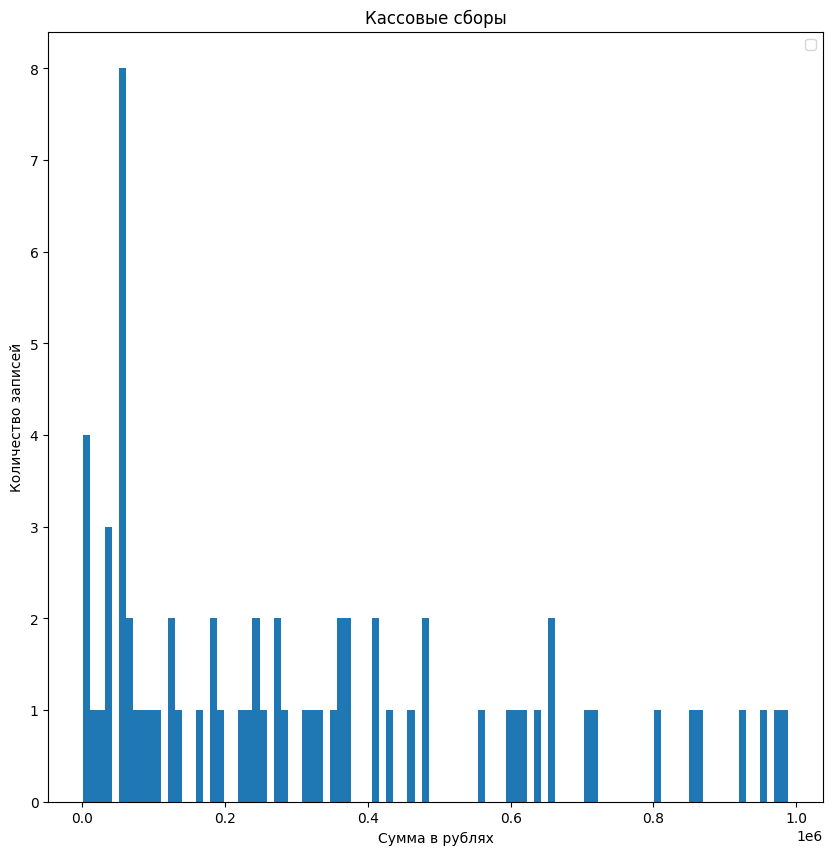

In [62]:
low_box_office = low_budget.query("box_office < 1_000_000")

fig, ax = plt.subplots(figsize =(10, 10))
ax.hist(low_box_office["box_office"], 100, histtype='bar')
ax.legend(prop={'size': 10})
ax.set_title('Кассовые сборы')
ax.set_xlabel('Сумма в рублях')
ax.set_ylabel('Количество записей')

Проанализировав "низкобюджетные" фильмы делаем вывод о моде финансовых показателей. Большинство фильмов получают временное финансирование в 4_000_000 рублей, безвозмездное финансирование в 2_400_000 рублей, имеют бюджет в 3_800_000 рублей и кассовые сборы в 50_000. Исходя из этого можно сделать вывод, что большинство картин убыточны.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера  </b></font>
    <br /> 
    <font size="3", color = "black">
<br /> На этом проекте мы работаем с продажами, поэтому включается другой фактор оценки выбросов, он отличается от того, что мы применяли на проекте про недвижимость
        
На этом проекте выбросы — это звезды, которые мы изучаем и добавляем информацию про них в итоговый вывод        
        
Стоит вернуть данные       

<div class="alert alert-info">
<font size="4", color = "black">Удалил набор данных с фильтрацией выбросов.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

Проанализируем, какую часть данных мы потеряли при подготовке.

In [63]:
after_puring = df.count()
print(f"Записей было до начала чистки: {before_puring}.")

Записей было до начала чистки: title                    7486
puNumber                 7486
show_start_date          7486
type                     7486
film_studio              7468
production_country       7484
director                 7477
producer                 6918
age_restriction          7486
refundable_support        332
nonrefundable_support     332
budget                    332
financing_source          332
ratings                  6519
genres                   6510
dtype: int64.


### Добавим новые столбцы

In [64]:
df["start_year"] = df["show_start_date"].dt.year
df["main_director"] = df["director"].str[0]
df["main_genre"] = df["genres"].str[0][0]
df["grant_share"] = (100 * (df["refundable_support"].add(df["nonrefundable_support"], fill_value=0) / df["budget"])).round(2)

df.head()

,index,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,start_year,main_director,main_genre,grant_share
0,0,открытый простор,221048915,2015-11-27,Художественный,"[Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пи...",[США],[Кевин Костнер],"[Дэвид Валдес, Кевин Костнер, Джейк Эбертс]",18,NaN,NaN,NaN,NaN,7.2,"[боевик, драма, мелодрама]",NaN,2015,Кевин Костнер,боевик,NaN
1,1,особо важное задание,111013716,2016-09-13,Художественный,"[Киностудия ""Мосфильм""]",[СССР],[Е.Матвеев],NaN,6,NaN,NaN,NaN,NaN,6.6,"[драма, военный]",NaN,2016,Е.Матвеев,боевик,NaN
2,2,особо опасен,221038416,2016-10-10,Художественный,"[Юниверсал Пикчерз, Кикстарт Продакшнз, Марк...",[США],[Тимур Бекмамбетов],"[Джим Лемли, Джейсон Нетер, Марк Е.Платт, Я...",18,NaN,NaN,NaN,NaN,6.8,"[фантастика, боевик, триллер]",NaN,2016,Тимур Бекмамбетов,боевик,NaN
3,5,остановился поезд,111013816,2016-09-13,Художественный,"[Киностудия ""Мосфильм""]",[СССР],[В.Абдрашитов],NaN,6,NaN,NaN,NaN,NaN,7.7,[драма],NaN,2016,В.Абдрашитов,боевик,NaN
4,6,любовь и голуби,111007013,2013-10-18,Художественный,"[Киностудия ""Мосфильм""]",[СССР],[В.Меньшов],NaN,12,NaN,NaN,NaN,NaN,8.3,"[мелодрама, комедия]",2700.0,2013,В.Меньшов,боевик,NaN


## EDA

Исследуем, сколько фильмов выходило в прокат каждый год.

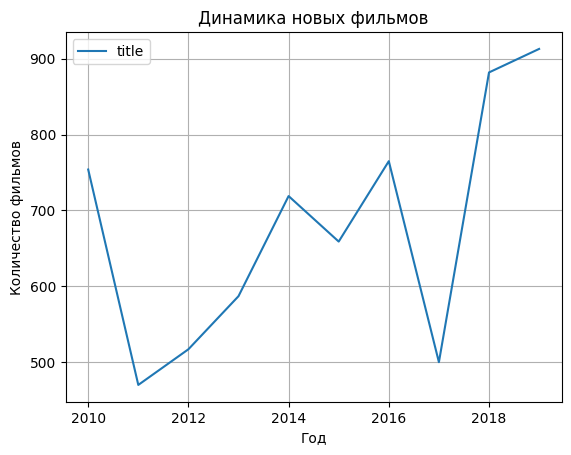

In [65]:
df.pivot_table(index="start_year", values="title", aggfunc="count").plot(xlabel="Год", \
    ylabel="Количество фильмов", grid=True, title="Динамика количества новых фильмов");

Частота выхода фильмов меняется год от года. В 2010'х выходило много фильмов. Потом, к 2011 году, количество новых фильмов сильно сократилось и медленно росло до 2014 года. В 2015 году произошёл недолгий спад и до 2016 года количество выходящих в прокат фильмов продолжало расти. Затем количество выпускаемых фильмов начало резко сокращаться к 2017 году. В 2018 году произошёл резкий рост количества новых фильмов, который продолжился в 2019 году с чуть меньшей динамикой.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br />  
    <font size="3", color = "black">
<br />Корректной оценке кол-ва фильмов, мешают почти 800 дублей в названиях фильмов

<div class="alert alert-info">
<font size="4", color = "black">Переписал замечания о динамике.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

Выясним долю фильмов с указанной информацией о прокате в кинотеатрах.

In [66]:
filled_share = 100 * df['box_office'].notna().sum() / len(df.index)

print(f"Доля фильмов с указанными кассовыми сборами: {filled_share:.2f}%")

Доля фильмов с указанными кассовыми сборами: 44.21%


### Изучим, как доля фильмов с информацией о их кассовых сборах менялась по годам

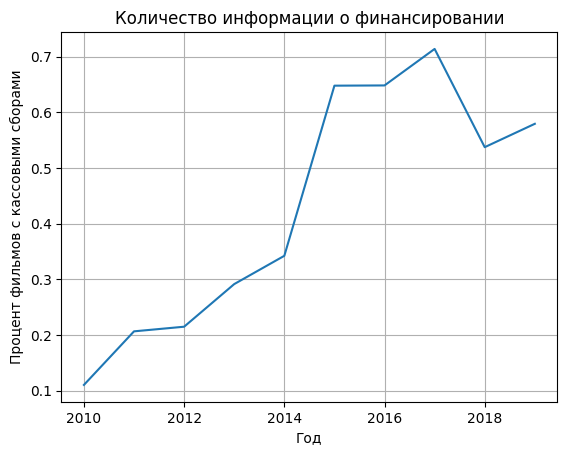

In [67]:
filled = df.pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["count", "size"]})
filled.columns = ["count", "size"]
filled["percent"] = filled["count"] / filled["size"]
filled["percent"].plot(xlabel="Год", ylabel="Процент фильмов с кассовыми сборами", grid=True, title="Количество информации о финансировании");

Количество информации о фильмах росло год от года. Наиболее полные данные представлены за 2015-2018 годы.

### Изучим как менялась динамика проката по годам

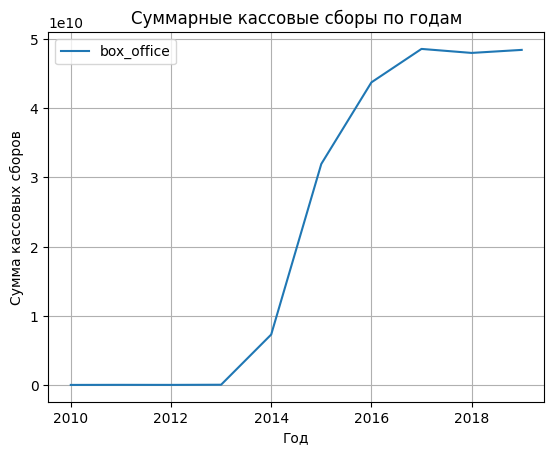

In [68]:
profits = df.pivot_table(index="start_year", values="box_office", aggfunc="sum").plot(xlabel="Год", \
    ylabel="Сумма кассовых сборов", grid=True, title="Суммарные кассовые сборы по годам");

Сумма кассовых сборов увеличивалась с 2013 года и достигла максимальных значений в 2016+ годах. Наибольшие кассовые сборы со всех фильмов пришлись на 2018 год. Минимальные же сборы были в 2013, 2014 годах. После 2014 года наблюдаем значительный рост. Есть гипотеза, что это может быть связано с началом существенного госфинансирования.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит отметить взрывной рост сборов в 2014 году, интересно с чем это может быть связано?

<div class="alert alert-info">
<font size="4", color = "black">Сформулировал гипотезу для дальнейшей проверки.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

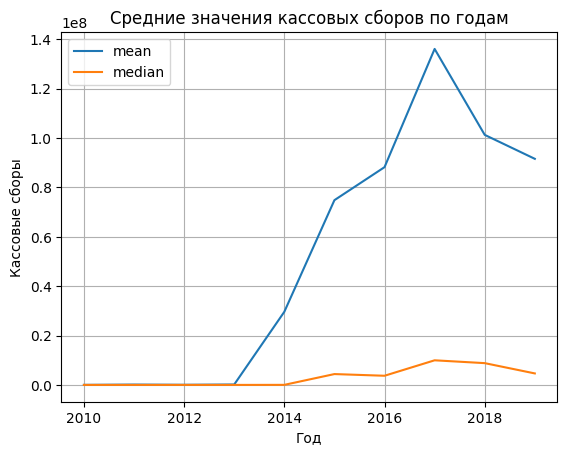

In [69]:
df.pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Кассовые сборы", grid=True, title="Средние значения кассовых сборов по годам");

После 2013 года средние значения кассовых сборов начали расти значительно быстрее медианных. Пик этого разрыва пришёлся на 2017 год. Из этого можно сделать вывод, что с 2013 года в прокате начали с каждым годом всё чаще появляться всё более и более успешные относительно других актуальных фильмов картины. При этом нужно отмасштабировать 2010-2013 годы для более детального анализа.

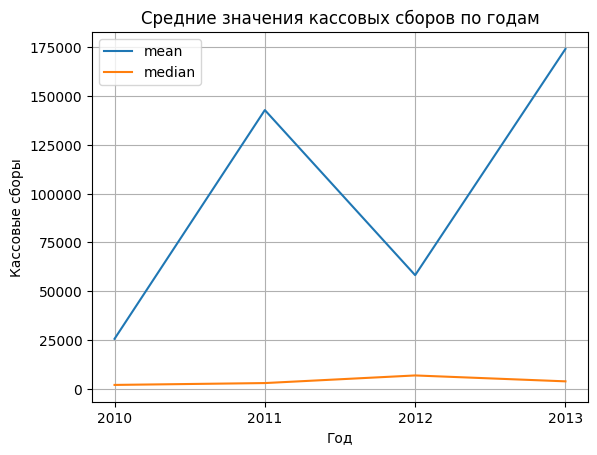

In [70]:
cropped_avg_box_office = df.query("start_year <= 2013").pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["mean", "median"]})
cropped_avg_box_office.plot(xlabel="Год", ylabel="Кассовые сборы", grid=True, title="Средние значения кассовых сборов по годам").set_xticks(cropped_avg_box_office.index);

С 2010 года до 2013 года средние значения также превосходили медианные. Разрыв с большего увеличивался год от года с исключением в 2011 году. 

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит поправить вывод: разница между медианой и средним значительна и в предыдущие годы, твой график скрывает эту разницу
        
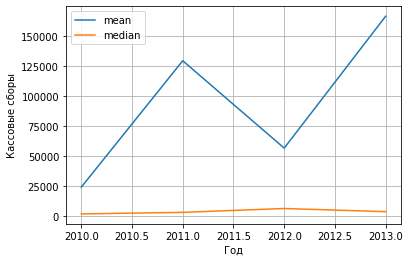        

<div class="alert alert-info">
<font size="4", color = "black">Исправил поверхностный вывод.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

### Определим влияние возрастного ограничения на сборы

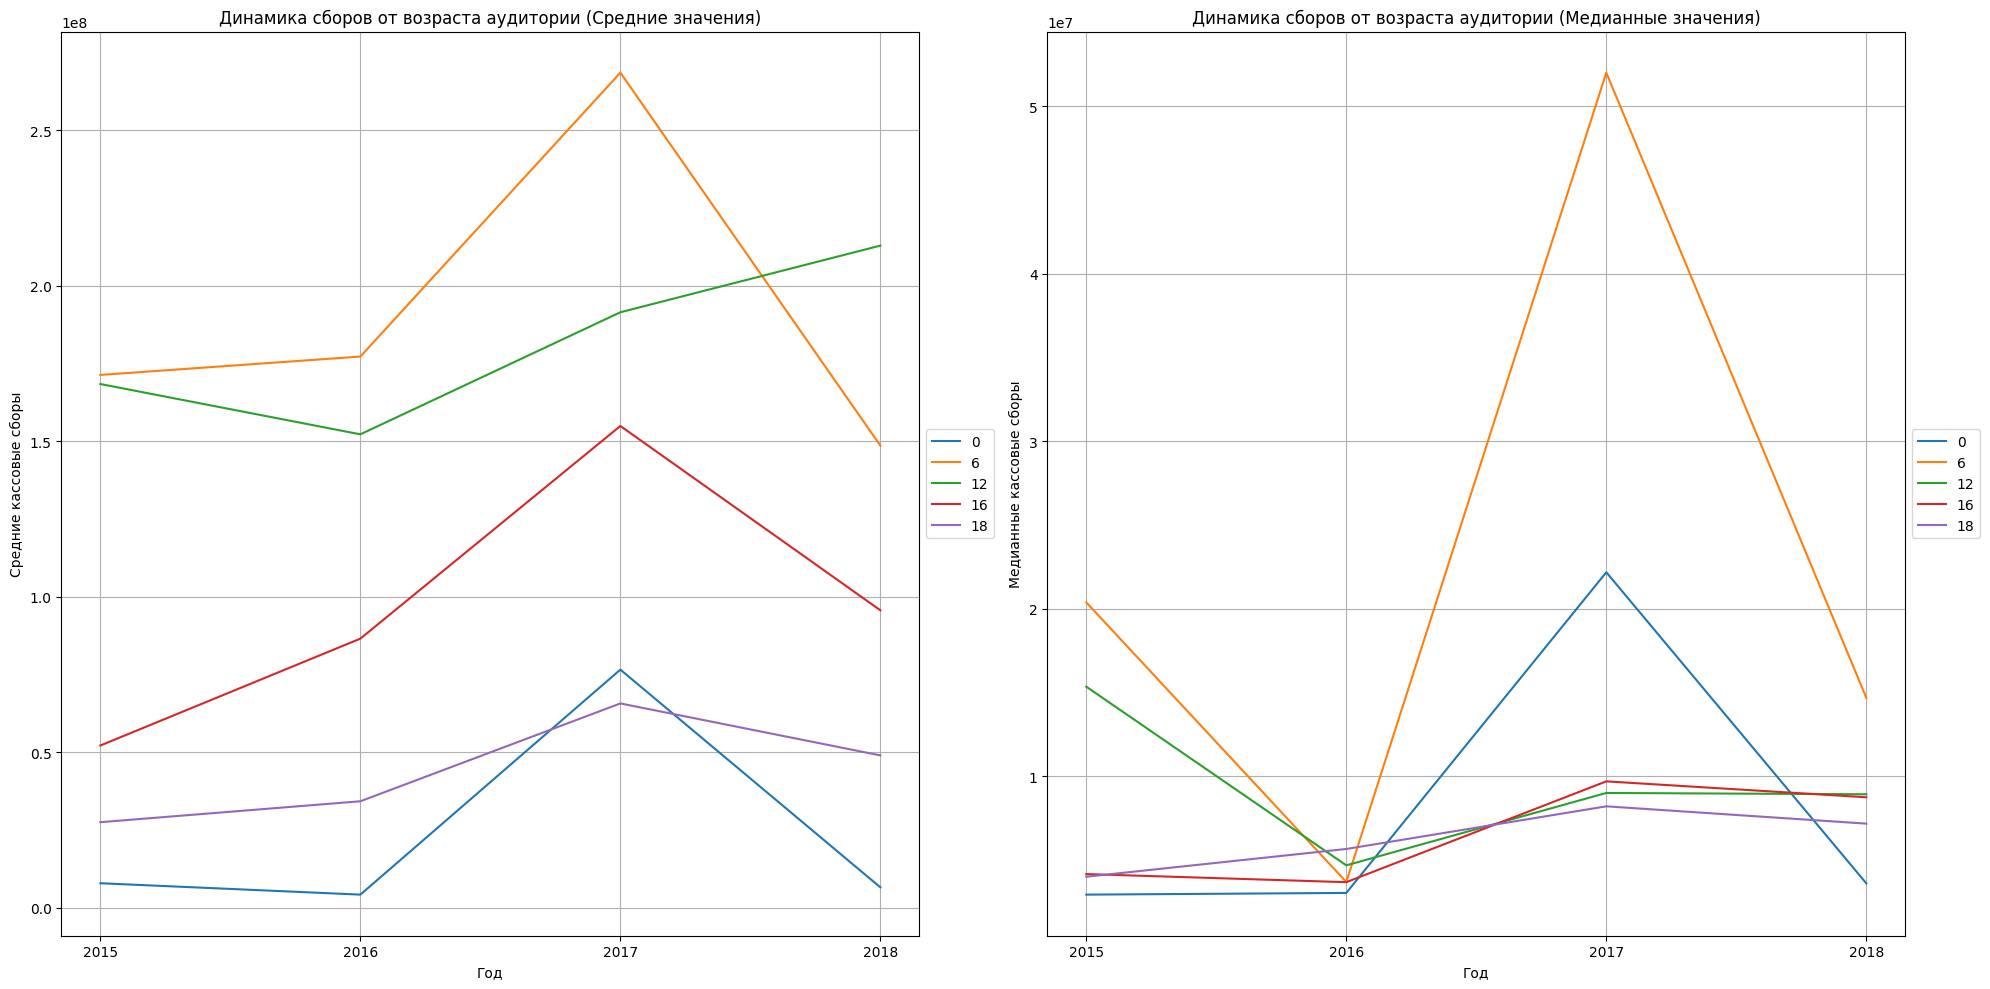

In [71]:
age_box_office_mean = df[(df['start_year'] >= 2015) & (df['start_year'] < 2019)] \
    .pivot_table(index="start_year", columns="age_restriction", values="box_office", aggfunc="mean")
age_box_office_median = df[(df['start_year'] >= 2015) & (df['start_year'] < 2019)] \
    .pivot_table(index="start_year", columns="age_restriction", values="box_office", aggfunc="median")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))

# График для средних значений
age_box_office_mean.plot(ax=ax0, xlabel="Год", ylabel="Средние кассовые сборы", grid=True, 
    title="Динамика сборов от возраста аудитории (Средние значения)")
ax0.set_xticks(age_box_office_mean.index)
ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# График для медианных значений
age_box_office_median.plot(ax=ax1, xlabel="Год", ylabel="Медианные кассовые сборы", grid=True, 
    title="Динамика сборов от возраста аудитории (Медианные значения)")
ax1.set_xticks(age_box_office_median.index)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️  Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
Можно подправить подписи оси х, в виде целых 2015, 2016 ..., 
        
Для графиков, построенных при помощи библиотеки matplotlib искать тему Ticks and ticklabels
        
https://matplotlib.org/stable/tutorials/text/text_intro.html
        
или
        
https://dev-gang.ru/article/izmenenie-czastoty-tikov-v-matplotlib-k5x1kznn39/?ysclid=lcp5si8pky848462627
        
для библиотеки plotly
        
https://plotly.com/python/tick-formatting/             

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит переместить легенду за край графика

<div class="alert alert-info">
<font size="4", color = "black">Сделал.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит полностью оформить все графики на проекте, осталось добавить названия для графиков

<div class="alert alert-info">
<font size="4", color = "black">Улучшил восприятие графиков их расположением.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

После анализа среднего и медианного значения кассовых сборов по годам в зависимости от возрастной категории фильмов очевидно, что наиболее успешны в прокате фильмы с возрастной категорией 6+. Однако, в силу демографических изменений этот тренд меняется в среднем в 2017 году т.к. в целевой аудитории 12+, вероятно, становится больше зрителей.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера  </b></font>
    <br /> 
    <font size="3", color = "black">
<br />Отлично — посмотрели и на средние значения сборов, и медианные. Осталось посмотреть на суммарные 

## Исследование государственного субсидирования

### Посмотрим на динамику суммарного субсидирования по годам

In [72]:
subsidized = df.query("refundable_support.notna() or nonrefundable_support.notna()")
subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 1163 to 6758
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   index                  330 non-null    int64   
 1   title                  330 non-null    object  
 2   pu_number              330 non-null    UInt32  
 3   show_start_date        330 non-null    category
 4   type                   330 non-null    object  
 5   film_studio            330 non-null    object  
 6   production_country     330 non-null    object  
 7   director               330 non-null    object  
 8   producer               328 non-null    object  
 9   age_restriction        330 non-null    uint8   
 10  refundable_support     111 non-null    float64 
 11  nonrefundable_support  321 non-null    float64 
 12  budget                 313 non-null    float64 
 13  financing_source       330 non-null    category
 14  ratings                312 non-null   

Рассмотрим суммарные значения финансируемых безвозмездно и с возвратом проектов.

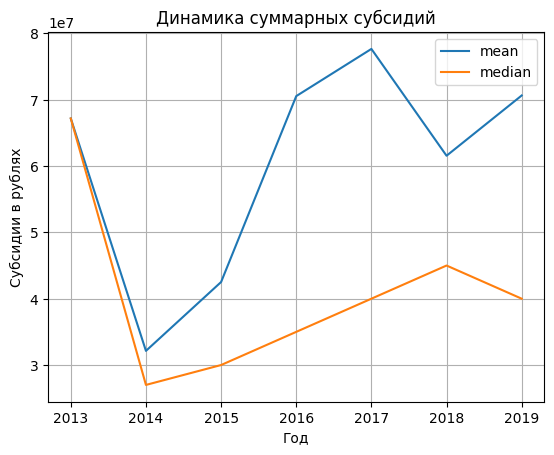

In [73]:
subsidized = subsidized.copy()
subsidized["grants"] = subsidized["nonrefundable_support"].add(subsidized["refundable_support"], fill_value=0)
avg_grants = pd.pivot_table(subsidized, index="start_year", values="grants", aggfunc={"grants" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Cубсидии в рублях", grid=True, title="Динамика суммарных субсидий");

Суммарные субсидии с большего растут год от года. При этом после 2015 года больше проектов начали получать большее относительно рынка субсидирование. При этом в 2018 году разрыв сильно сократился, что может означать более аккуратное распределение бюджета субсидирования.

Рассмотрим далее подробнее динамику временных субсидий.

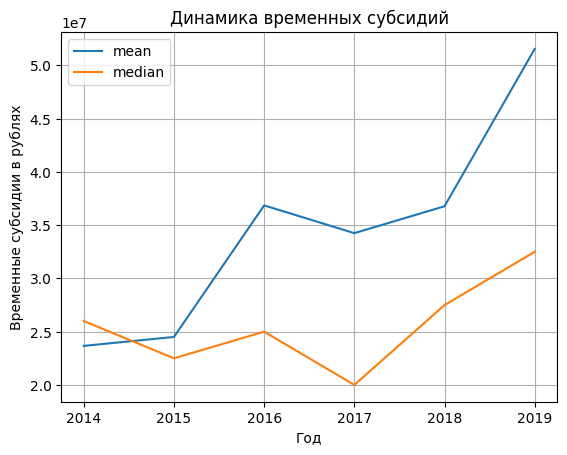

In [74]:
subsidized.pivot_table(index="start_year", values="refundable_support", aggfunc={"refundable_support" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Временные субсидии в рублях", grid=True, title="Динамика временных субсидий");

Заметим, что после 2013 года начали появляться проекты, которые получали больше временных субсидий, чем большинство остальных субсидируемых проектов.

Посмотрим, сколько всего субсидируемых с условием возврата денег фильмов было по годам.

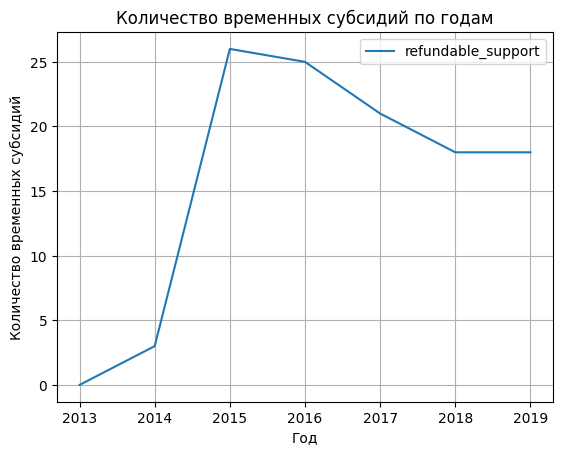

In [75]:
subsidized.pivot_table(index="start_year", values="refundable_support", aggfunc="count") \
.plot(xlabel="Год", ylabel="Количество временных субсидий", grid=True, title="Количество временных субсидий по годам");

Заметим, что количество временных субсидий отдалённо напоминает динамику суммарных кассовых сборов, что подтверждает нашу гипотезу о взрывном росте кассовых сборов в 2015 году.

Проанализируем безвозмездные субсидии таким же образом.

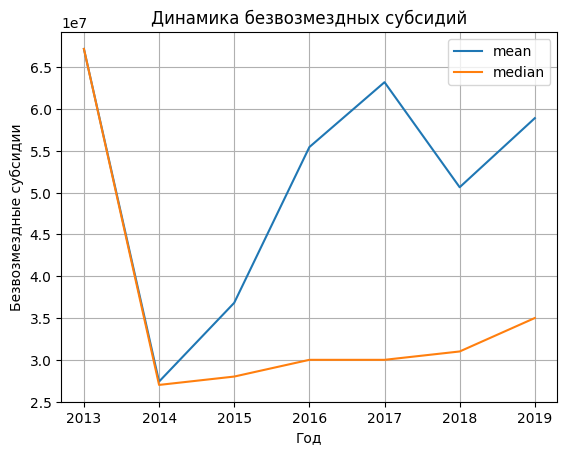

In [76]:
subsidized.pivot_table(index="start_year", values="nonrefundable_support", aggfunc={"nonrefundable_support" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Безвозмездные субсидии", grid=True, title="Динамика безвозмездных субсидий");

Заметим, что безвозмездные субсидии резко падали с 2013 до 2014 года. После 2015 года начался рост безвозмездных субсидий каждый год есть проекты, которые получали безвозмездных субсидий чуть больше, чем остальные. Вероятно, такая динамика связана с реорганизацей в пользу оборонного бюджета.

Посмотрим, сколько всего безвозмездно субсидируемых фильмов было по годам.

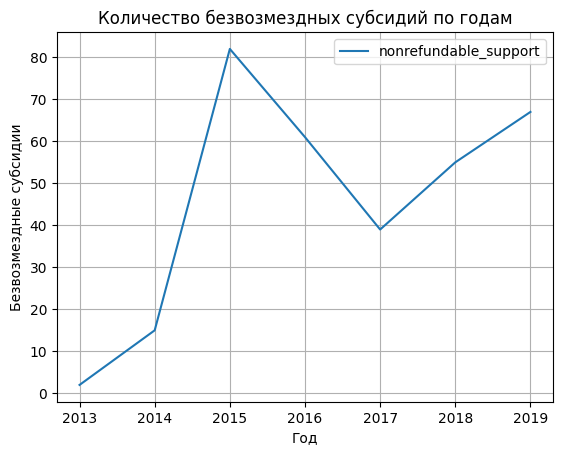

In [77]:
subsidized.pivot_table(index="start_year", values="nonrefundable_support", aggfunc="count") \
    .plot(xlabel="Год", ylabel="Безвозмездные субсидии", grid=True, title="Количество безвозмездных субсидий по годам");

Динамика схожа со временными субсидиями, за исключением того, что в 2017 году безвозмездных субсидий начали давать значительно меньше, чем до этого.

### Проанализируем как субсидии влияют на коммерческую успешность проектов

Сначала рассмотрим временные, потом безвозмездные.

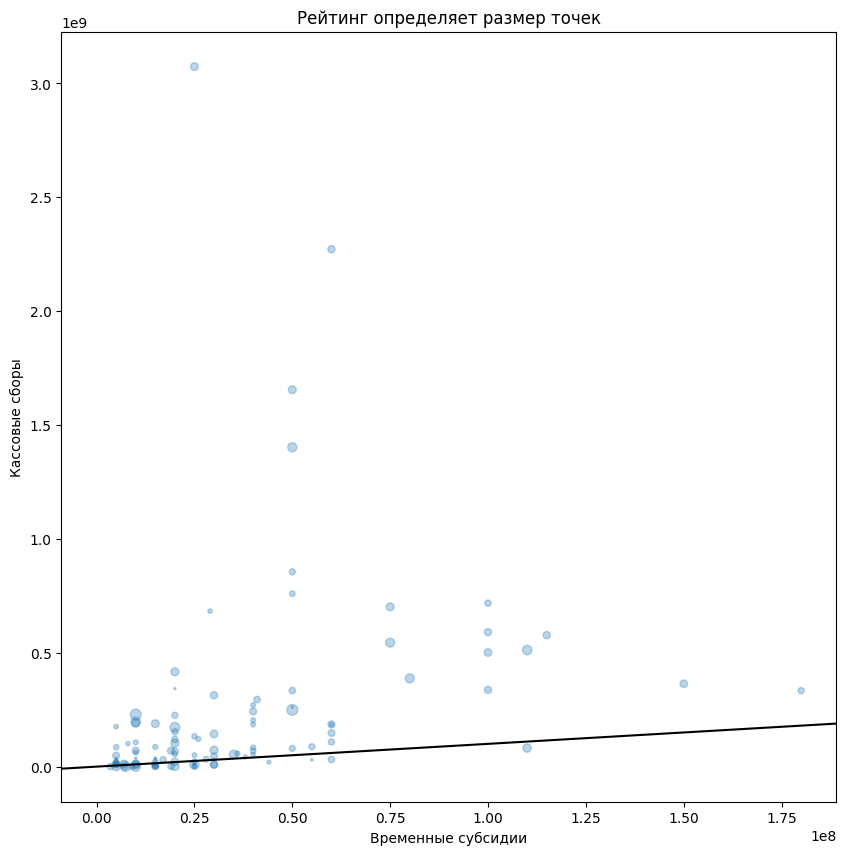

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))


ax.scatter(x=subsidized['refundable_support'], y=subsidized['box_office'], 
           s=subsidized['ratings'] ** 3 / 10, alpha=0.3)
ax.axline((0, 0), (1, 1), color='k')
ax.set_xlabel("Временные субсидии")
ax.set_ylabel("Кассовые сборы")
ax.set_title("Рейтинг определяет размер точек")

plt.show()

Заметим, что большинство фильмов смогли превзойти размер временных субсидий кассовыми сборами. При этом рейтинг, который определяет размер точек на графике, чаще больший у фильмов, которые получили меньше прибыли либо вовсе убыточны.

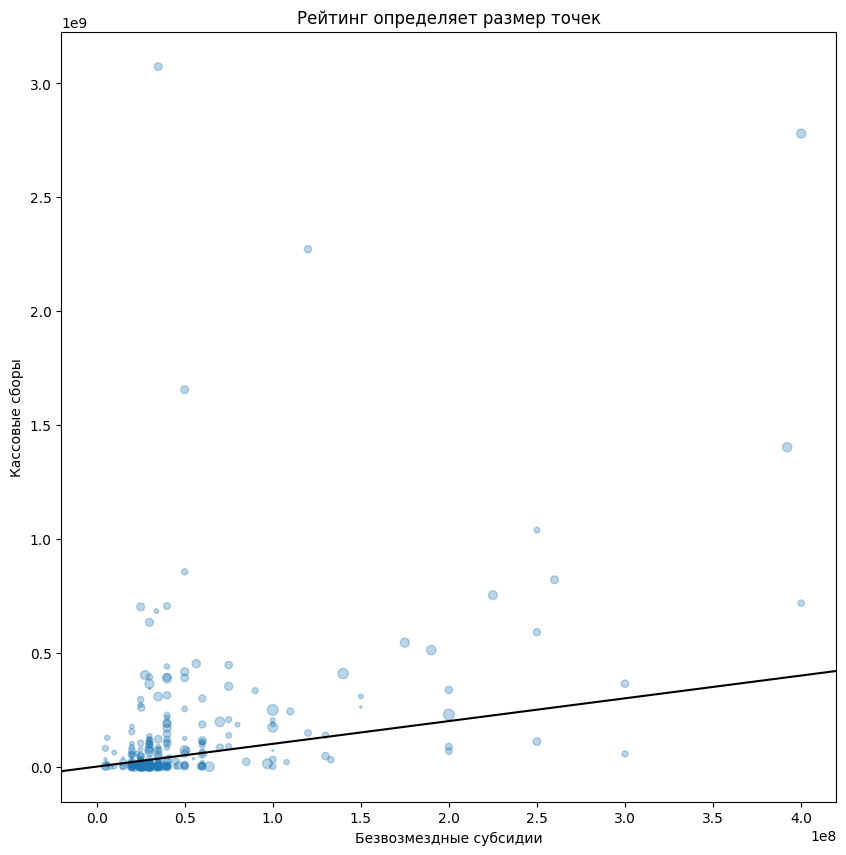

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x=subsidized['nonrefundable_support'], y=subsidized['box_office'], 
           s=subsidized['ratings'] ** 3 / 10, alpha=0.3)
ax.axline((0, 0), (1, 1), color='k')
ax.set_xlabel("Безвозмездные субсидии")
ax.set_ylabel("Кассовые сборы")
ax.set_title("Рейтинг определяет размер точек")
plt.show()

При безвозмездных субсидиях меньшее количество картин становится прибыльными. Также заметно, что рейтинг картин не зависит от их кассовой успешности либо объёма безсозмездного субсидирования. Также заметно, что большее количество картин получают субсидии в районе 25_000_000 рублей и не достигают кассовой успешности либо выходят в безубыток.

Рассмотрим схожий график для суммарных субсидий.

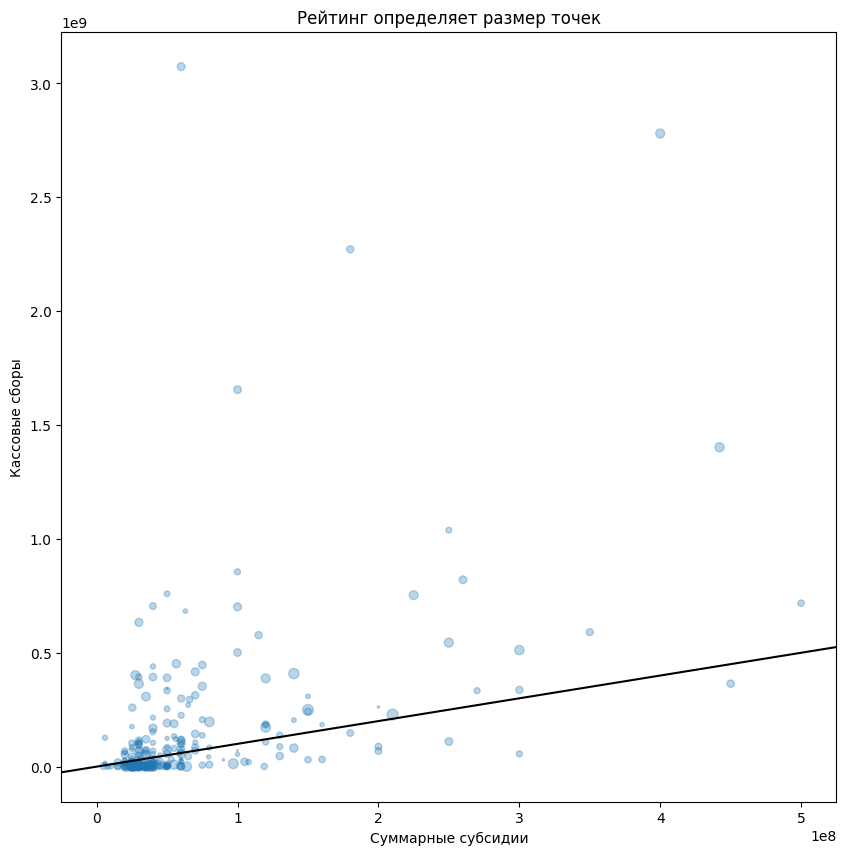

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x=subsidized['grants'], y=subsidized['box_office'], 
           s=subsidized['ratings'] ** 3 / 10, alpha=0.3)
ax.axline((0, 0), (1, 1), color='k')
ax.set_xlabel("Суммарные субсидии")
ax.set_ylabel("Кассовые сборы")
ax.set_title("Рейтинг определяет размер точек")
plt.show()

Видмио, большая часть фильмов не окупает субсидии. Рассчитаем точное отношение количества субсидий к кассовым сборам.

In [120]:
print(f"Отношение суммарных субсидий к суммарным кассовым сборам субсидируемых проектов составляет: {100 * ( 1 - subsidized['grants'].sum() / subsidized['box_office'].sum()):.2f}%")

Отношение суммарных субсидий к суммарным кассовым сборам субсидируемых проектов составляет: 52.22%


### Рассмотрим, какими признаками обладают финансово успешные проекты

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Широкие строки кода рекомендуется делить на всем проекте
        
<a href="https://qastack.ru/programming/53162/how-can-i-do-a-line-break-line-continuation-in-python">Перенос длинных строк кода</a>. 
    
</div>

<div class="alert alert-info">
<font size="4", color = "black">Постарался везде улучшить читаемость переносами кода.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

In [80]:
# subsidized

In [81]:
subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 1163 to 6758
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   index                  330 non-null    int64   
 1   title                  330 non-null    object  
 2   pu_number              330 non-null    UInt32  
 3   show_start_date        330 non-null    category
 4   type                   330 non-null    object  
 5   film_studio            330 non-null    object  
 6   production_country     330 non-null    object  
 7   director               330 non-null    object  
 8   producer               328 non-null    object  
 9   age_restriction        330 non-null    uint8   
 10  refundable_support     111 non-null    float64 
 11  nonrefundable_support  321 non-null    float64 
 12  budget                 313 non-null    float64 
 13  financing_source       330 non-null    category
 14  ratings                312 non-null   

In [82]:
succeded_subsidized = subsidized.loc[subsidized["grants"] > subsidized["box_office"]]
succeded_subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1163 to 6655
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   index                  198 non-null    int64   
 1   title                  198 non-null    object  
 2   pu_number              198 non-null    UInt32  
 3   show_start_date        198 non-null    category
 4   type                   198 non-null    object  
 5   film_studio            198 non-null    object  
 6   production_country     198 non-null    object  
 7   director               198 non-null    object  
 8   producer               198 non-null    object  
 9   age_restriction        198 non-null    uint8   
 10  refundable_support     46 non-null     float64 
 11  nonrefundable_support  196 non-null    float64 
 12  budget                 194 non-null    float64 
 13  financing_source       198 non-null    category
 14  ratings                182 non-null   

In [122]:
print(f"Доля фильмов, окупивших субсидии составляет: {100 * len(succeded_subsidized.index) / len(subsidized.index):.2f}%")

Доля фильмов, окупивших субсидии составляет: 60.00%


<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
         Рассмотрим, какими признаками обладают финансово успешные проекты
        
Скажи пожалуйста, получилось ли у тебя корректно отфильтровать успешные фильмы этим кодом?
        
        succeded_subsidized = subsidized[subsidized["refundable_support"] + subsidized["nonrefundable_support"] > subsidized["box_office"]]
        succeded_subsidized.info()

<div class="alert alert-info">
<font size="4", color = "black">Исправил баг с суммированием субсидий.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

Выделим категориальные признаки, которые влияют на успешность картины. 

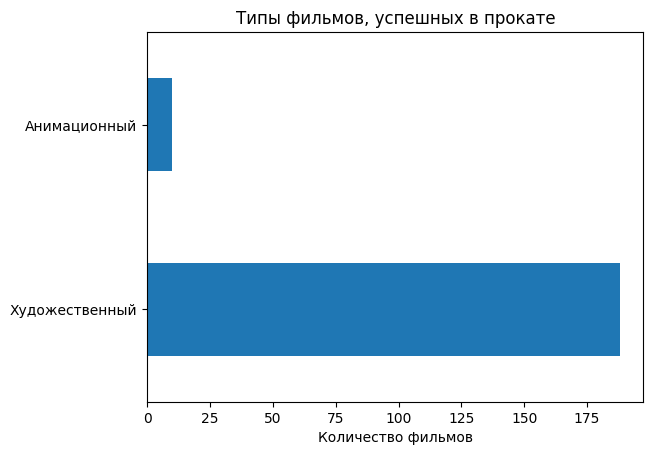

In [83]:
successfull_types = succeded_subsidized["type"].value_counts().loc[succeded_subsidized["type"].value_counts() > 0]

fig, ax = plt.subplots()

successfull_types.plot.barh(ax=ax, title="Типы фильмов, успешных в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Предположим, что более успешными в прокате являются художественные фильмы. 

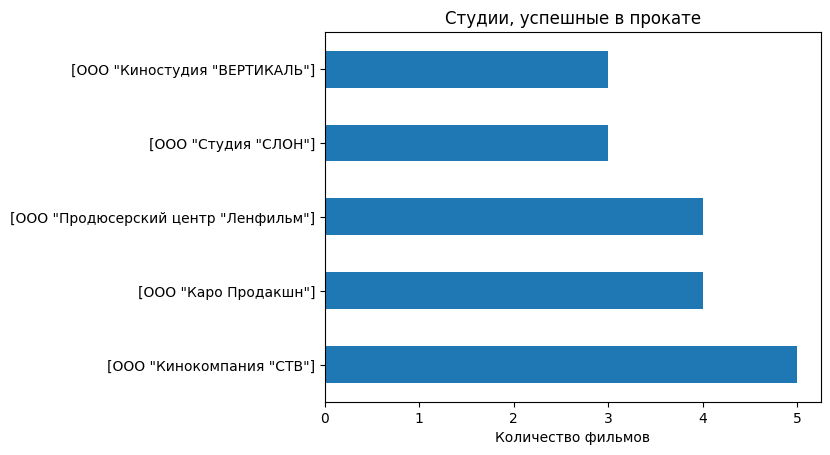

In [84]:
successfull_studios = succeded_subsidized["film_studio"].value_counts().loc[succeded_subsidized["film_studio"].value_counts() > 2]
fig, ax = plt.subplots()

successfull_studios.plot.barh(ax=ax, title="Студии, успешные в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список студий, которые чаще всего добиваются коммерческого успеха при получении субсидий.

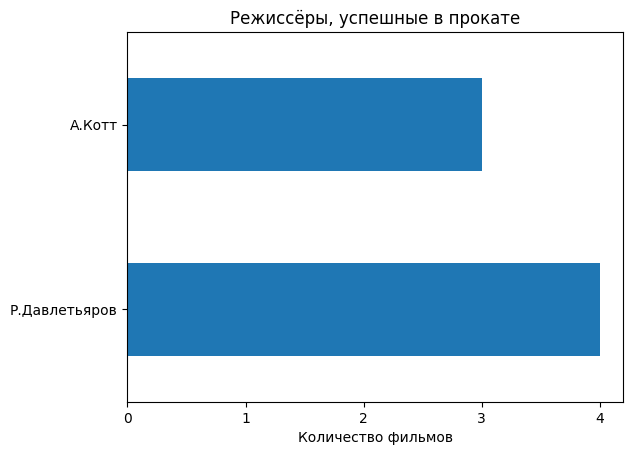

In [85]:
successfull_directors = succeded_subsidized["main_director"].value_counts().loc[succeded_subsidized["main_director"].value_counts() > 2]
fig, ax = plt.subplots()

successfull_directors.plot.barh(ax=ax, title="Режиссёры, успешные в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список режиссёров, которые чаще остальных делают коммерчиски успешные проекты с учётом субсидирования.

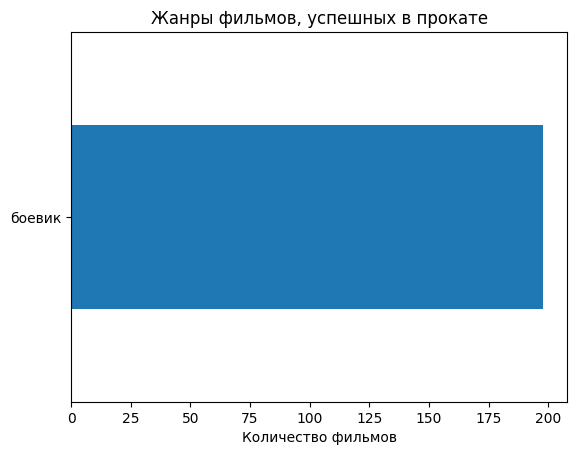

In [86]:
successfull_genres = succeded_subsidized["main_genre"].value_counts().loc[succeded_subsidized["main_genre"].value_counts() > 2]

fig, ax = plt.subplots()

successfull_genres.plot.barh(ax=ax, title="Жанры фильмов, успешных в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Выяснили, что единственным жанром, подходящим для субсидирования с целью получения коммерчески успешной картины является боевик. Кажется, это основная зарактеристика успешности т.к. все фильмы, которые были успешны были сняты в этом жанре.

Далее проанализируем, какие проекты наоборот с большой долей вероятности не добъются коммерческого успеха. Выделим те из них, успешность которых хуже медианной.

In [87]:

failed_subsidized = subsidized.loc[subsidized.index.difference(succeded_subsidized.index)]
failed_subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 1696 to 6758
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   index                  132 non-null    int64   
 1   title                  132 non-null    object  
 2   pu_number              132 non-null    UInt32  
 3   show_start_date        132 non-null    category
 4   type                   132 non-null    object  
 5   film_studio            132 non-null    object  
 6   production_country     132 non-null    object  
 7   director               132 non-null    object  
 8   producer               130 non-null    object  
 9   age_restriction        132 non-null    uint8   
 10  refundable_support     65 non-null     float64 
 11  nonrefundable_support  125 non-null    float64 
 12  budget                 119 non-null    float64 
 13  financing_source       132 non-null    category
 14  ratings                130 non-null   

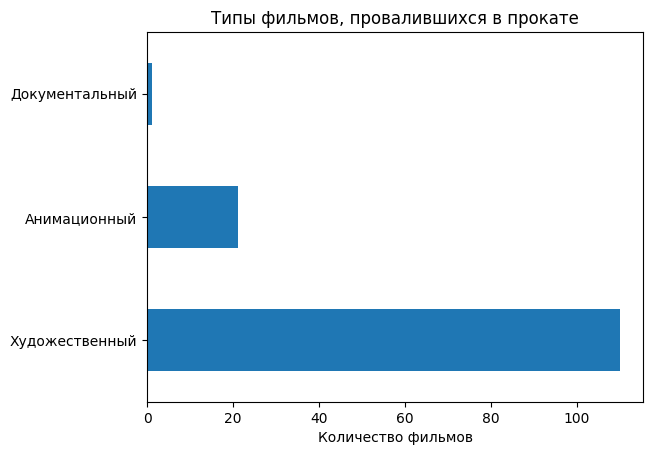

In [88]:
fail_types = failed_subsidized["type"].value_counts().loc[failed_subsidized["type"].value_counts() > 0]

fig, ax = plt.subplots()

fail_types.plot.barh(ax=ax, title="Типы фильмов, провалившихся в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Т.к. было достаточно успешных художественных т анимационных фильмов, делаем вывод, что толлько документальные фильмы склонны к провалу в прокате.

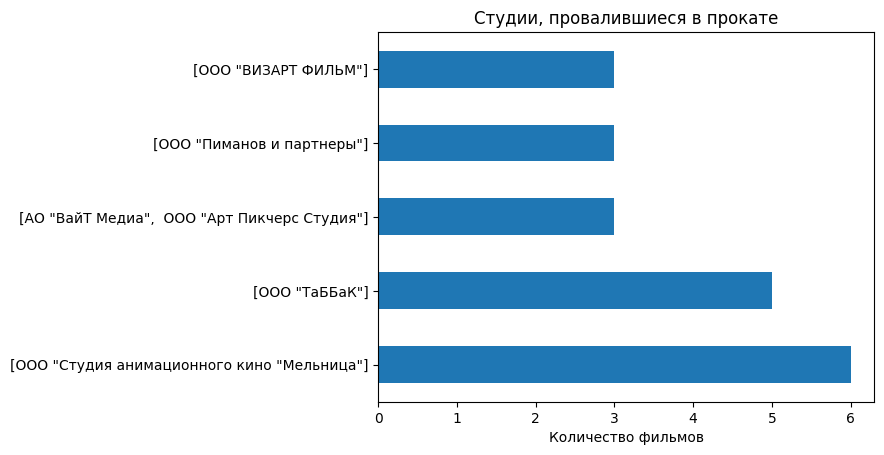

In [89]:
fail_studios = failed_subsidized["film_studio"].value_counts().loc[failed_subsidized["film_studio"].value_counts() > 2]
fig, ax = plt.subplots()

fail_studios.plot.barh(ax=ax, title="Студии, провалившиеся в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список студий, которые чаще всего убыточны при получении субсидий.

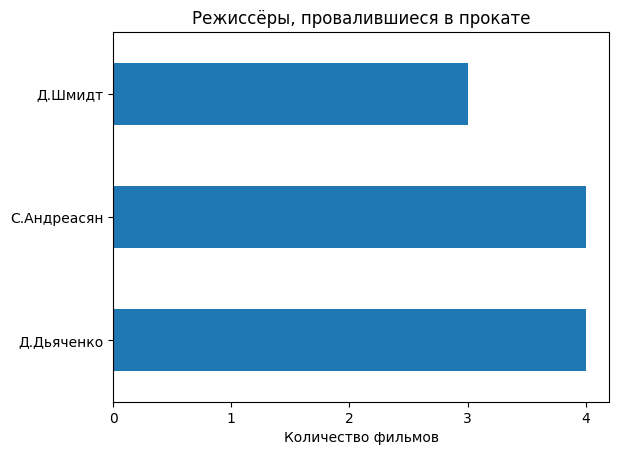

In [90]:
fail_directors = failed_subsidized["main_director"].value_counts().loc[failed_subsidized["main_director"].value_counts() > 2]
fig, ax = plt.subplots()

fail_directors.plot.barh(ax=ax, title="Режиссёры, провалившиеся в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Получили список режиссёров, которые чаще остальных снимают убыточные картины.

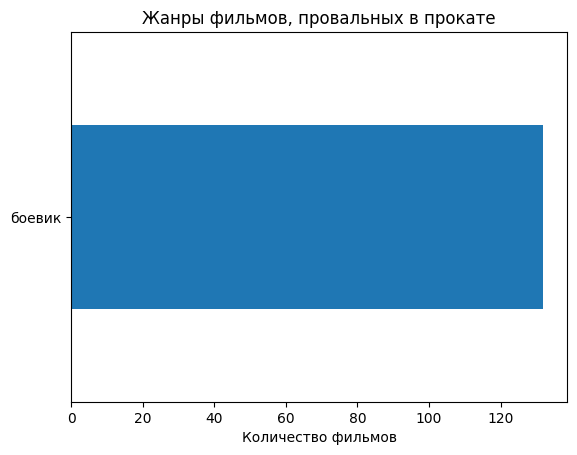

In [91]:
fail_genres = failed_subsidized["main_genre"].value_counts().loc[failed_subsidized["main_genre"].value_counts() > 2]

fig, ax = plt.subplots()

fail_genres.plot.barh(ax=ax, title="Жанры фильмов, провальных в прокате")
ax.set_xlabel("Количество фильмов")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Т.к. боевики также являются наиболее часто встречающимся провальным жанром, опровергаем вывод о коммерческой успешности фильмов в этом жанре.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит полностью  поправить этот подраздел

<div class="alert alert-info">
<font size="4", color = "black">Улучшил качество графиков, переписал выводы после исправления бага в количестве успешных и провальных фильмов.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

### Проанализируем зависимость рейтинга проектов от субсидий 

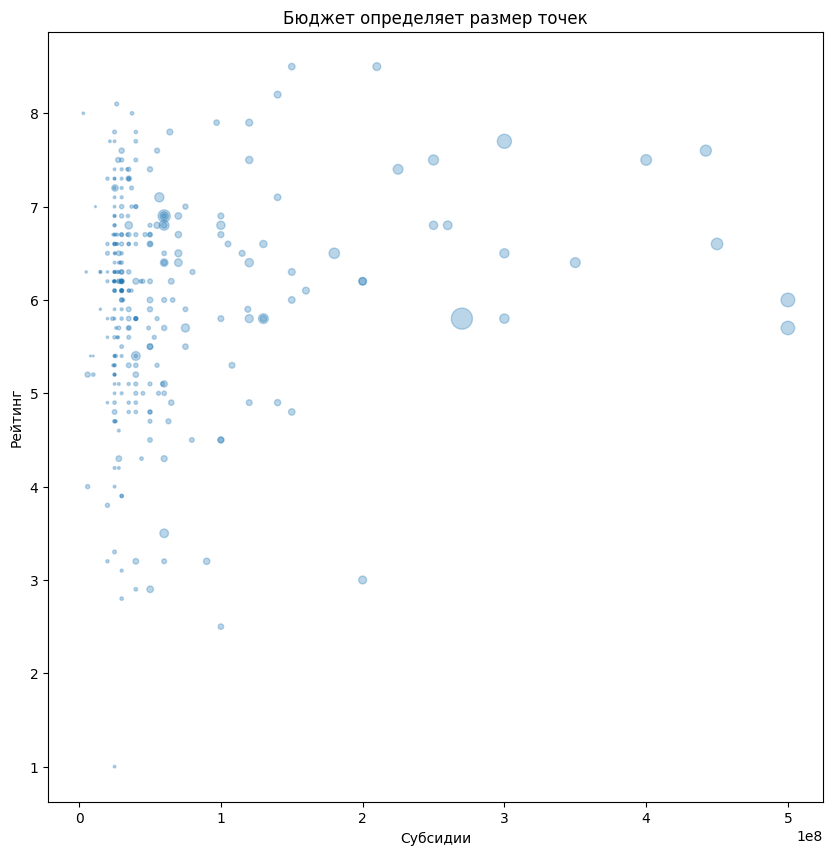

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x=subsidized["grants"], y=subsidized["ratings"], s=subsidized["budget"] / 10 ** 7, alpha=0.3);
ax.set_xlabel("Субсидии")
ax.set_ylabel("Рейтинг")
ax.set_title("Бюджет определяет размер точек")
plt.show()

Делаем вывод, что влияние бюджета на рейтинг незначительно. При этом часто наилучшие показатили рейтинга встречаются у картин, размер субсидий которых менее 70_000_000 рублей. Из этого можно сделать вывод, что финансирование на большие суммы часто бывает неэффективно.

Выделим ТОП-10 успешных режиссеров, которые получили и гос поддержку, и обеспечили огромные суммы сборов.

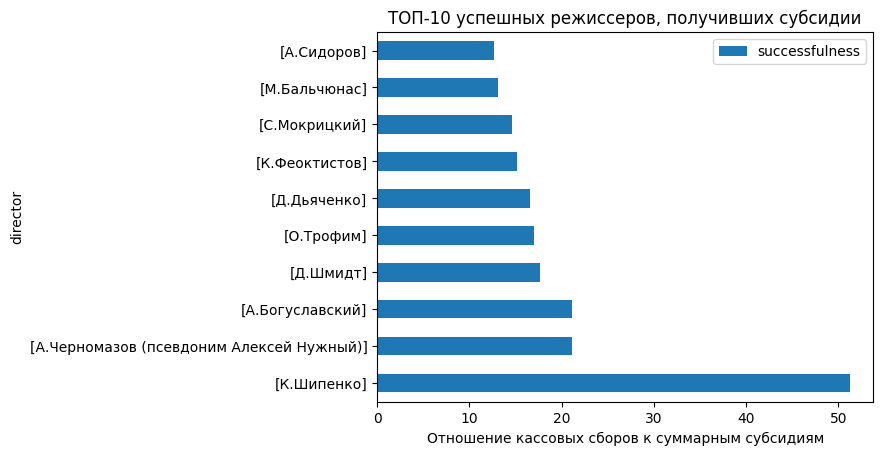

In [116]:
subsidized["successfulness"] = (subsidized["box_office"] / subsidized["grants"]).round(2)

top_success = subsidized.sort_values("successfulness", ascending=False).head(10)

fig, ax = plt.subplots()

top_success.plot.barh(x="director", y="successfulness", ax=ax, title="ТОП-10 успешных режиссеров, получивших субсидии")
ax.set_xlabel("Отношение кассовых сборов к суммарным субсидиям")
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

Так, стоит выдавать субсидии режиссёрам из списка учитывая их коммерческий успех.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br />
    <font size="3", color = "black">
<br /> Стоит отметить ТОП-10 успешных режиссеров, которые получили и гос поддержку, и обеспечили огромные суммы сборов, чтобы ответить на доп. вопрос — "Кому выдавать деньги в следующем году?"

<div class="alert alert-info">
<font size="4", color = "black">Получил список успещных режиссёров и сделал вывод о необходимости их поддержки.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
__Стоит посмотреть на антилидеров, которые принесли суперубытки — ТОП-10__

<div class="alert alert-info">
<font size="4", color = "black">Добавил подобное исследование.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

## Oбщий вывод

В исследовании была произведена подготовка данных:
 - преобразование типов данных
 - объединение источников данных в один набор
 - анализ пропусков в данных
 - устранение дубликатов
 - создан набор данных без выбросов в количественных данных 
 - созданы для удобства синтетические атрибуты данных
 - проанализировано количество утраченых после подготовки данных

В ходе подготовки данных ознакомились с основными количественными и качественными характеристиками данных.

Анализ показал, что:
 - Количество новых фильмов часто менялось год от года.
 - Доля фильмов с указанными кассовыми сборами: 44.21%
 - Количество информации о фильмах росло год от года. Наиболее полные данные представлены за 2015-2018 годы
 - Сумма кассовых сборов увеличивалась с 2013 года и достигла максимальных значений в 2016+ годах. Наибольшие кассовые сборы со всех фильмов пришлись на 2017 год. Минимальные же сборы были в 2013, 2014 годах.
 - Наиболее успешны в прокате фильмы с возрастной категорией 6+. Однако появилась гипотеза, что в силу демографических изменений этот тренд меняется в 2017 году т.к. в целевой аудитории 12+, вероятно, становится больше зрителей.
 - Суммарные субсидии с большего растут год от года.
 - Количество субсидий позитивно влияет на количество кассовых сборов.
 - 60% фильмов смогли превзойти размер временных субсидий кассовыми сборами.
 - Удалось выделить списки студий и режиссёров, которые чаще остальных выпускают коммерчески успешные картины.
 - Влияние бюджета на рейтинг незначительно.
 - Финансирование на большие чем 70_000_000 рублей суммы часто бывает неэффективно.
 - Получен список режиссёров, которые добиваются кассового успеха.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Выполнено исследование с интересным подходом к реализации кода и подготовке данных, молодец

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
        
Стоит перепроверить результаты и итоговый вывод после   исправления всех комментариев 
    

<div class="alert alert-info">
<font size="4", color = "black">Переписал вывод в соответствии с доработками в исследовании.</font>
    <br /> 
    <font size="3", color = "black">
<br />      

<div class="alert alert-success">
<font size="5", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />   
Ты выполнил практически все пункты проекта, молодец! Проведен значительный объем исследования 
        
        
Критические ❌ комментарии: 
               
 + объяснить какая основная проблема категориальных данных
 + выполнить поиск аномалий в количественных данных  
 + определить успешных режиссеров на гос поддержке        
 + прочие
 + перепроверить промежуточные и итоговый выводы после всех исправлений         
          
        
        
        
Стоит обратить внимание на ⚠️ комментарии...        
        
Если будут вопросы про мои комментарии - задавай, если какой-то формат взаимодействия не устраивает или есть какие-то другие пожелания - пиши :)

<div class="alert alert-success">
    <font size="5", color= "seagreen"><b>Жду твой проект и твои комментарии 🤝</b></font><br />

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />    Может пригодиться
    
[Обработка пропусков в данных](https://loginom.ru/blog/missing)
     
        
[Подробное руководство по группировке и агрегированию с помощью pandas](https://dfedorov.spb.ru/pandas/%D0%9F%D0%BE%D0%B4%D1%80%D0%BE%D0%B1%D0%BD%D0%BE%D0%B5%20%D1%80%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D0%BE%20%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B5%20%D0%B8%20%D0%B0%D0%B3%D1%80%D0%B5%D0%B3%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E%20%D1%81%20%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E%20pandas.html)
 
 
    
[8 способов фильтрации фреймов данных Pandas](https://questu.ru/articles/85248/)    
    
[Визуализация](https://dfedorov.spb.ru/pandas/%D0%AD%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20Matplotlib.html)
 
        
[Постер «Графики, которые убеждают всех»](https://www.notion.so/6c5ae8ceb8b5411e907c93c9b5e6a44e)         

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Если добавить запятую или знак нижнего подчеркивания, будет удобнее смотреть на большие числа
        
        pd.options.display.float_format = '{:,.2f}'.format
        
        pd.options.display.float_format = '{:_.2f}'.format